# Preprocessing

In [14]:
import glob
import os
import sys
import numpy as np
import pandas as pd
import tifffile as tif
import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage
import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
n_channels = 2
n_cycles = 5

img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
img_size = img.shape[:2]

X = np.zeros((n_channels*n_cycles, 1, *img_size))
k = 0
for i in range(n_channels):
    for j in range(n_cycles):
        fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
        print(fn)
        img = tif.imread(fn)
        X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
        k = k+1

./data/crisprmap20210506/amp-ch1-cycle0.tiff
./data/crisprmap20210506/amp-ch1-cycle1.tiff
./data/crisprmap20210506/amp-ch1-cycle2.tiff
./data/crisprmap20210506/amp-ch1-cycle3.tiff
./data/crisprmap20210506/amp-ch1-cycle4.tiff
./data/crisprmap20210506/amp-ch2-cycle0.tiff
./data/crisprmap20210506/amp-ch2-cycle1.tiff
./data/crisprmap20210506/amp-ch2-cycle2.tiff
./data/crisprmap20210506/amp-ch2-cycle3.tiff
./data/crisprmap20210506/amp-ch2-cycle4.tiff


In [11]:
img.shape

(2048, 1792, 4)

In [12]:
X.shape

(10, 1, 2048, 1792)

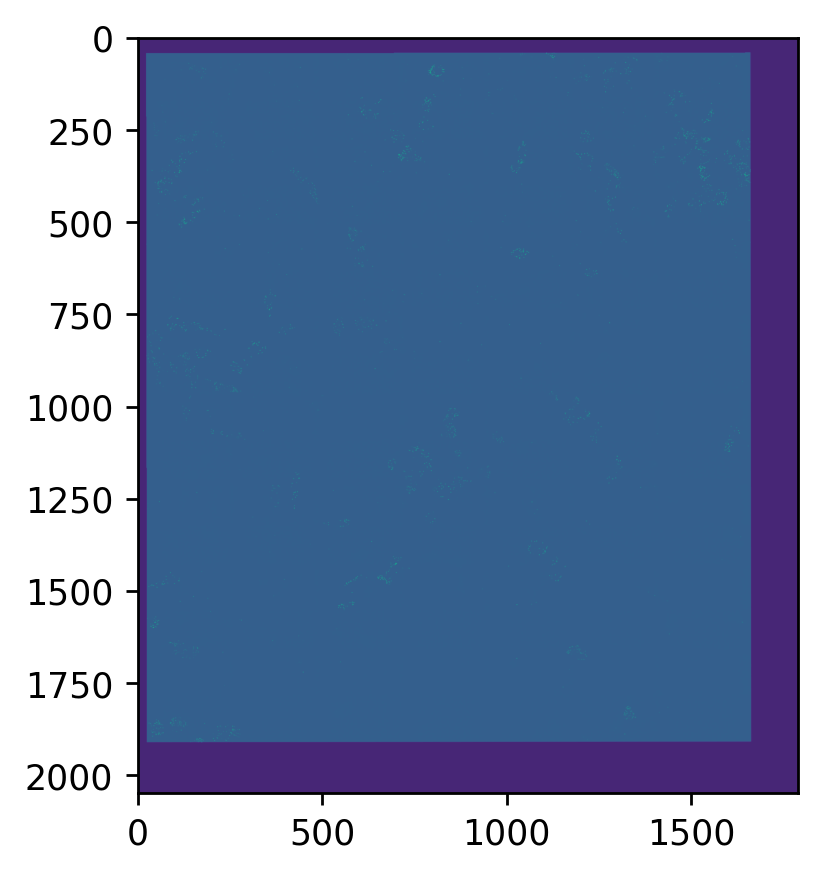

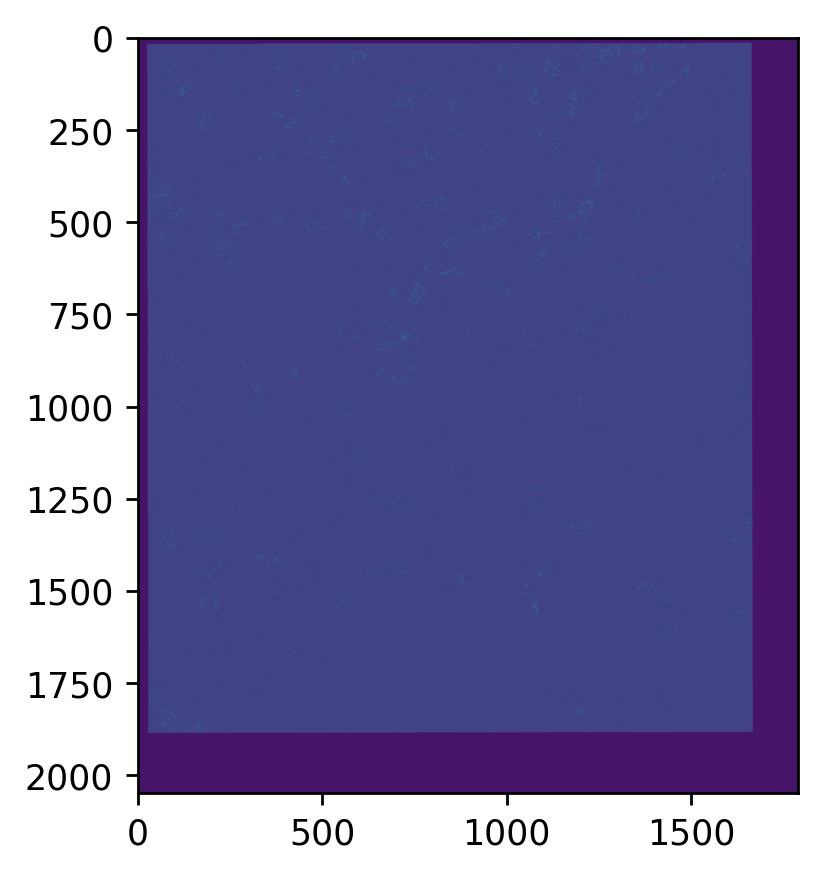

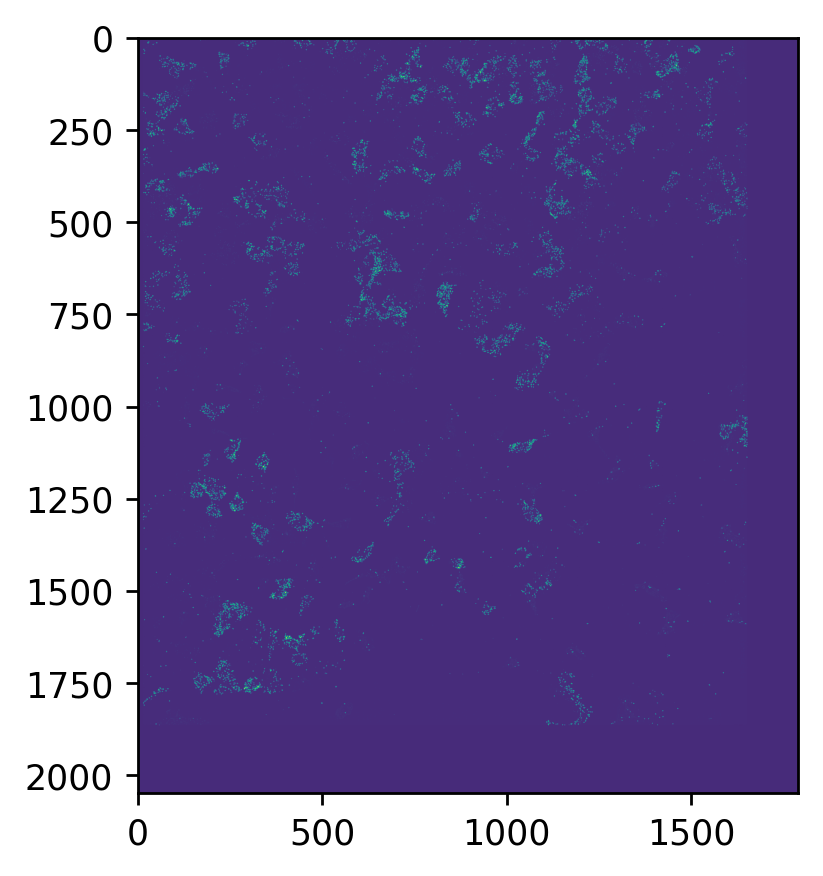

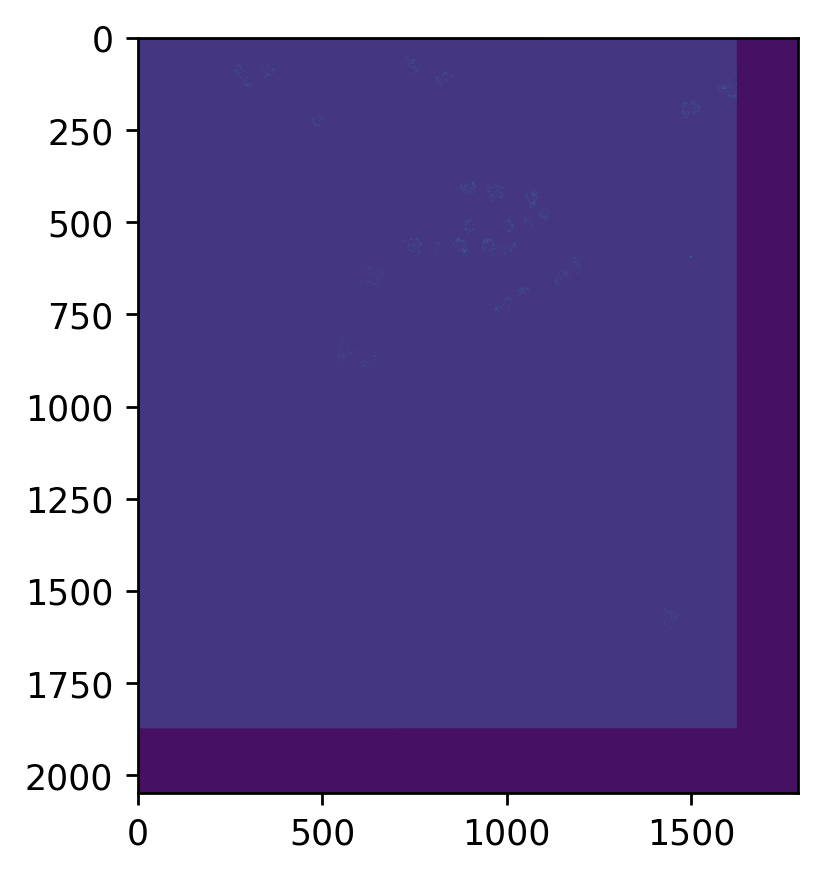

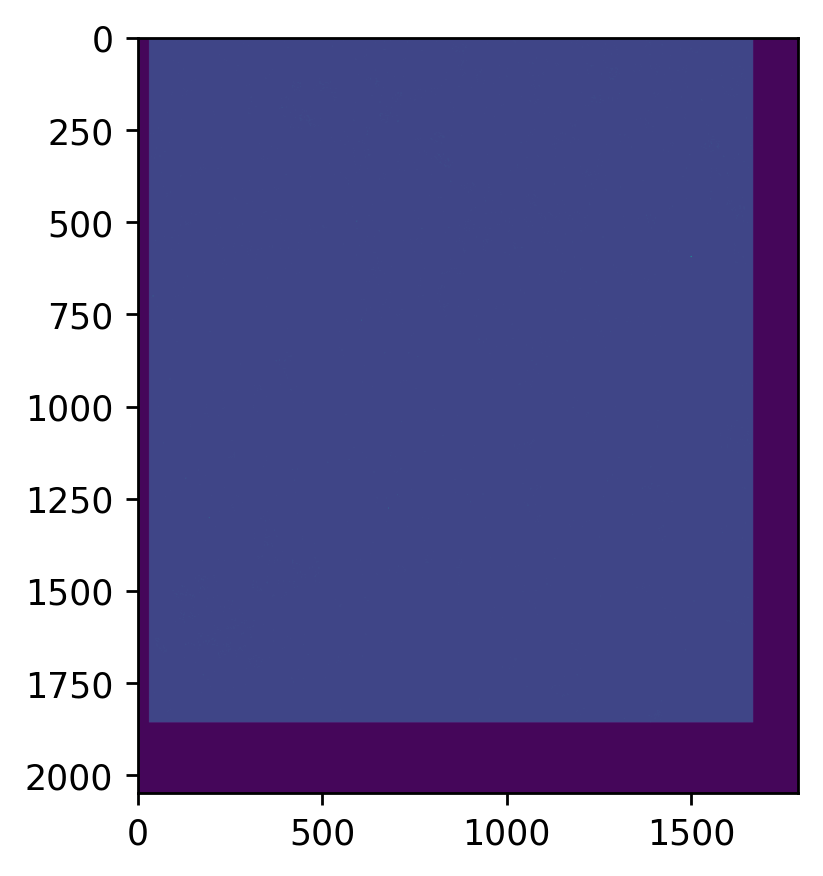

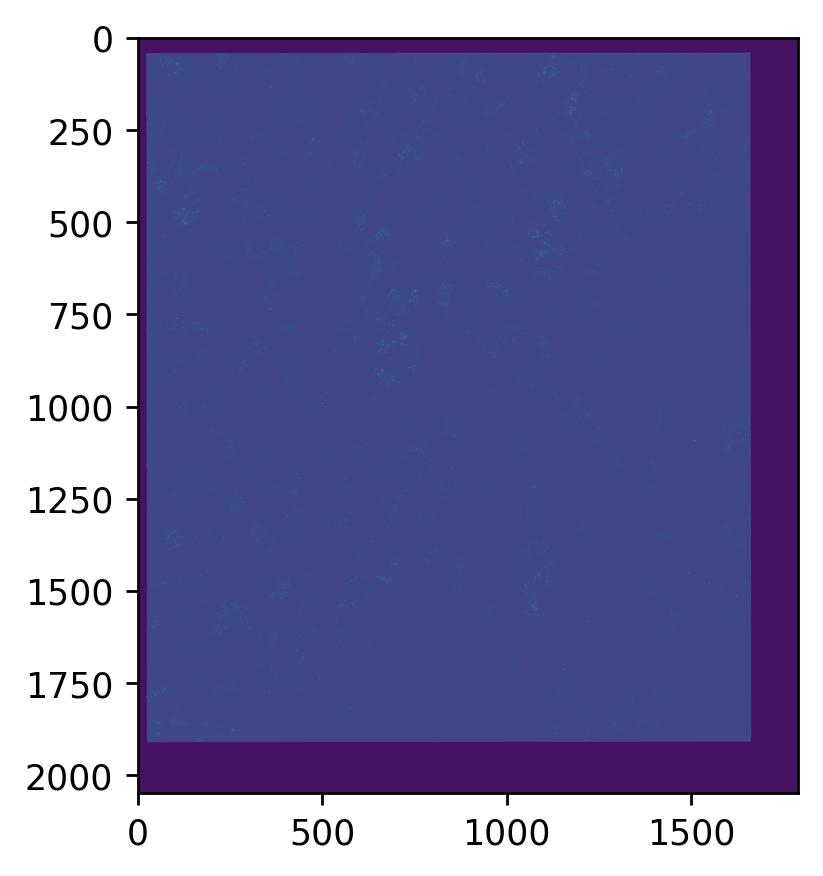

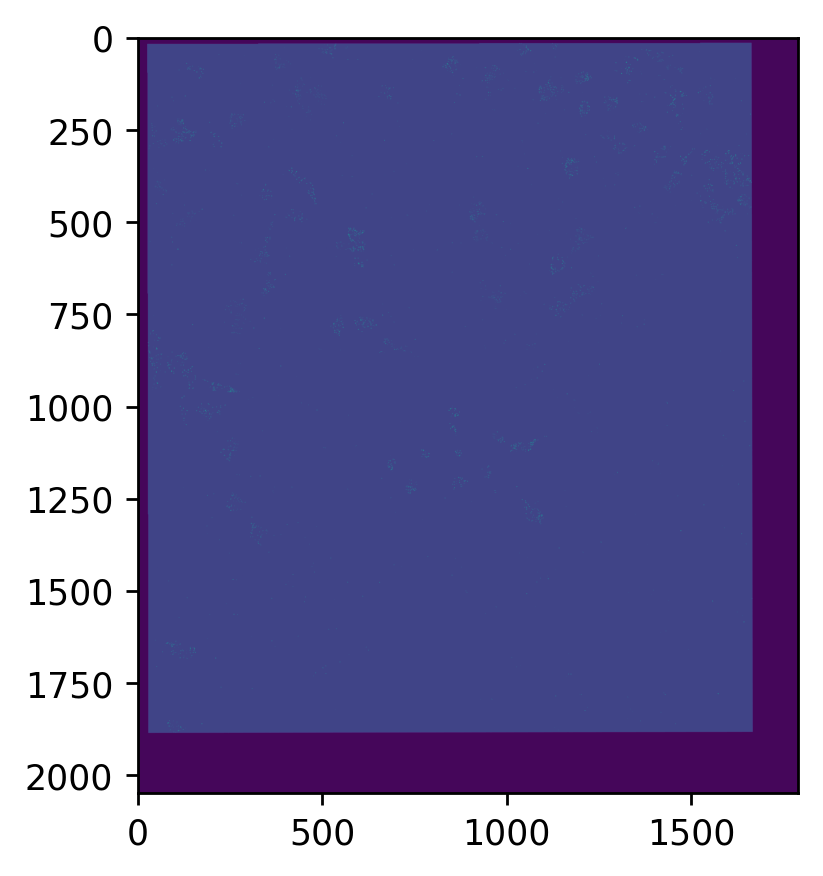

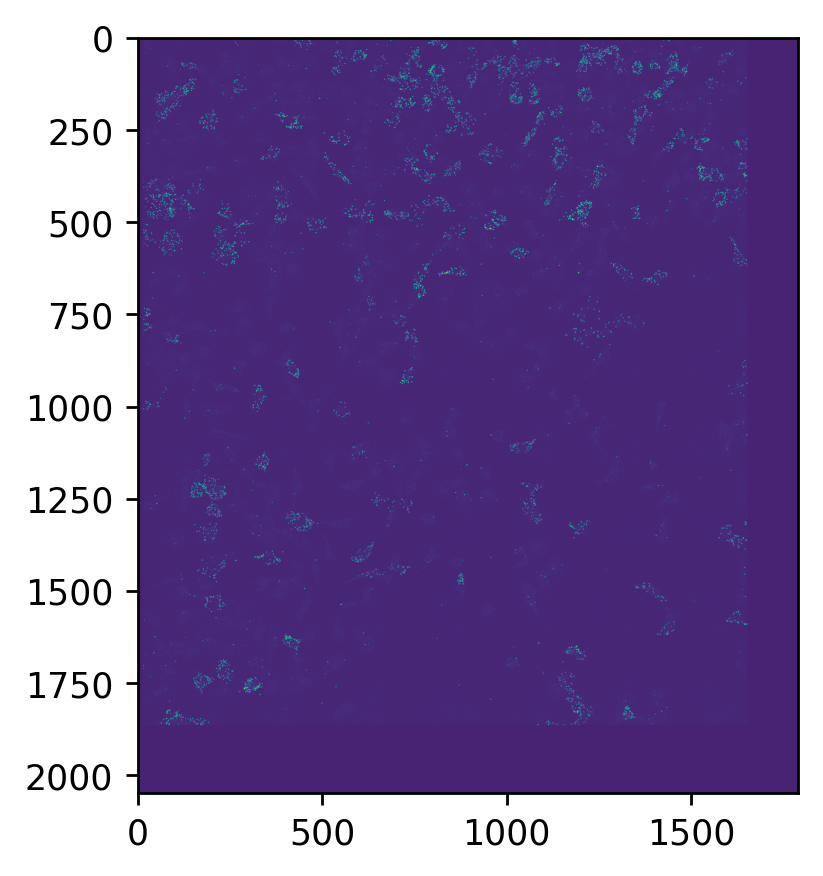

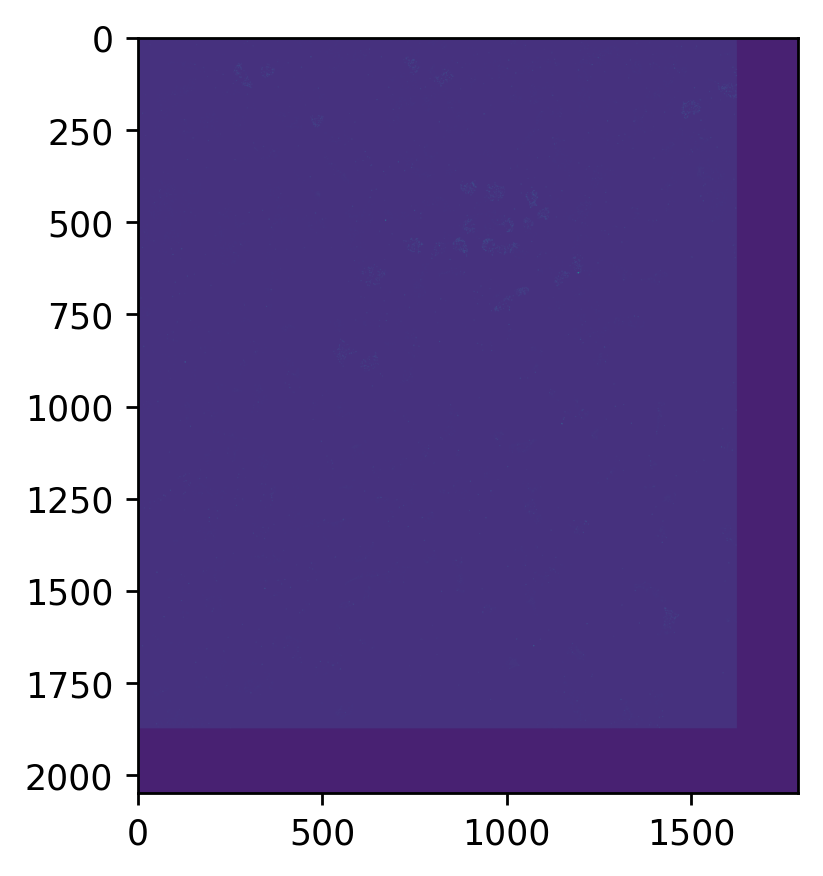

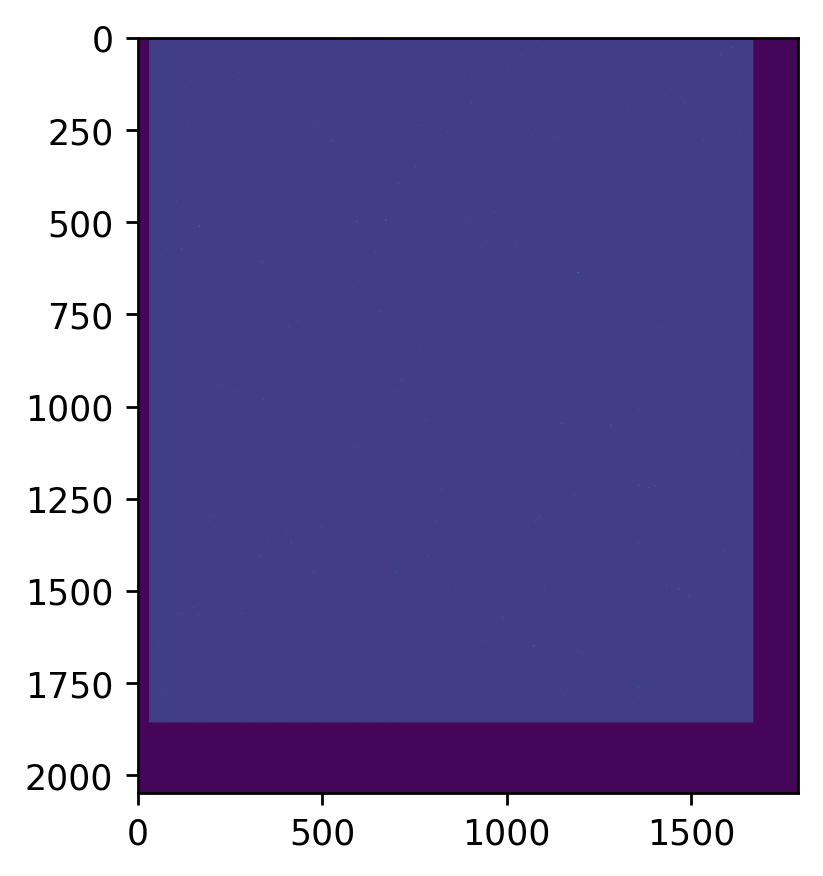

In [14]:
for i in range(X.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

(-0.5, 19.5, 19.5, -0.5)

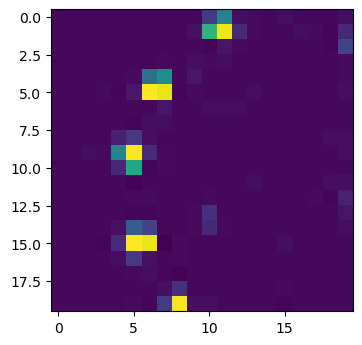

In [3]:
img = tif.imread('./data/registered-updated/amp-ch1-cycle2.tiff')
plt.figure(dpi=100)
plt.imshow(img[80:100, 80:100, 1])
plt.axis('image')
# im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

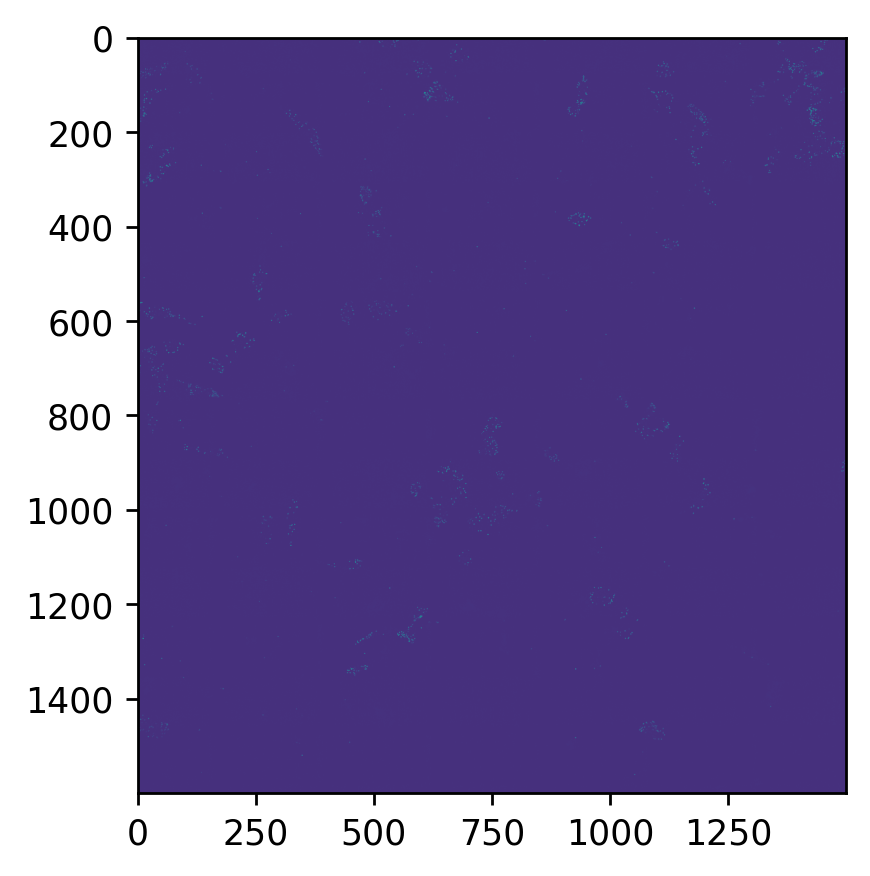

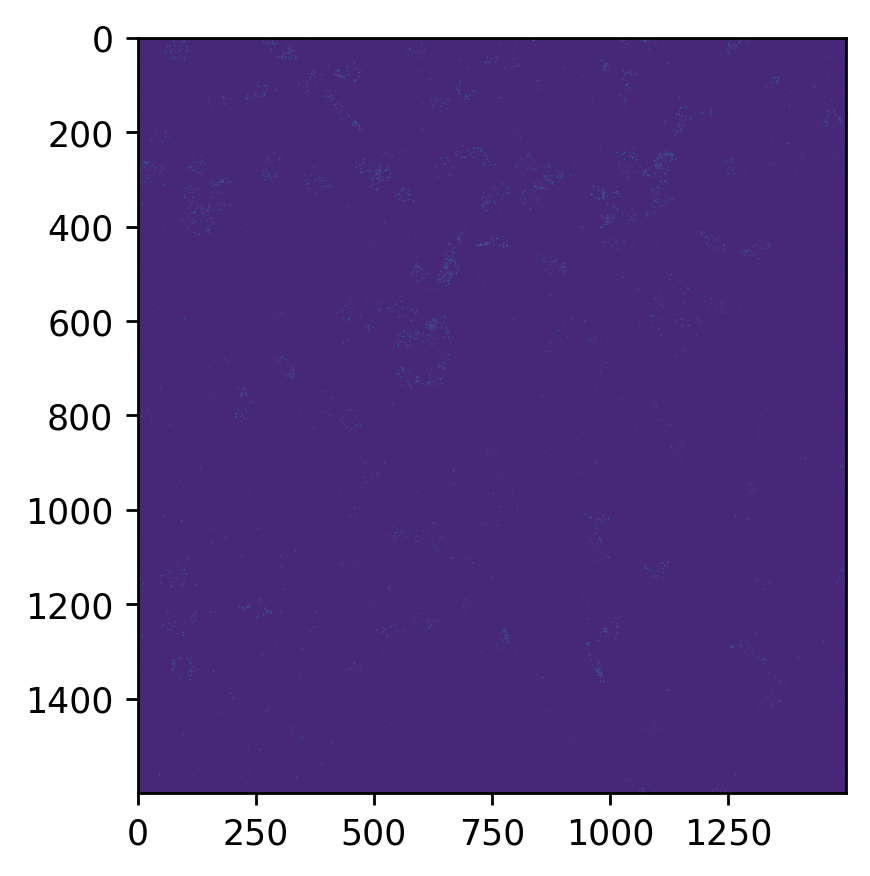

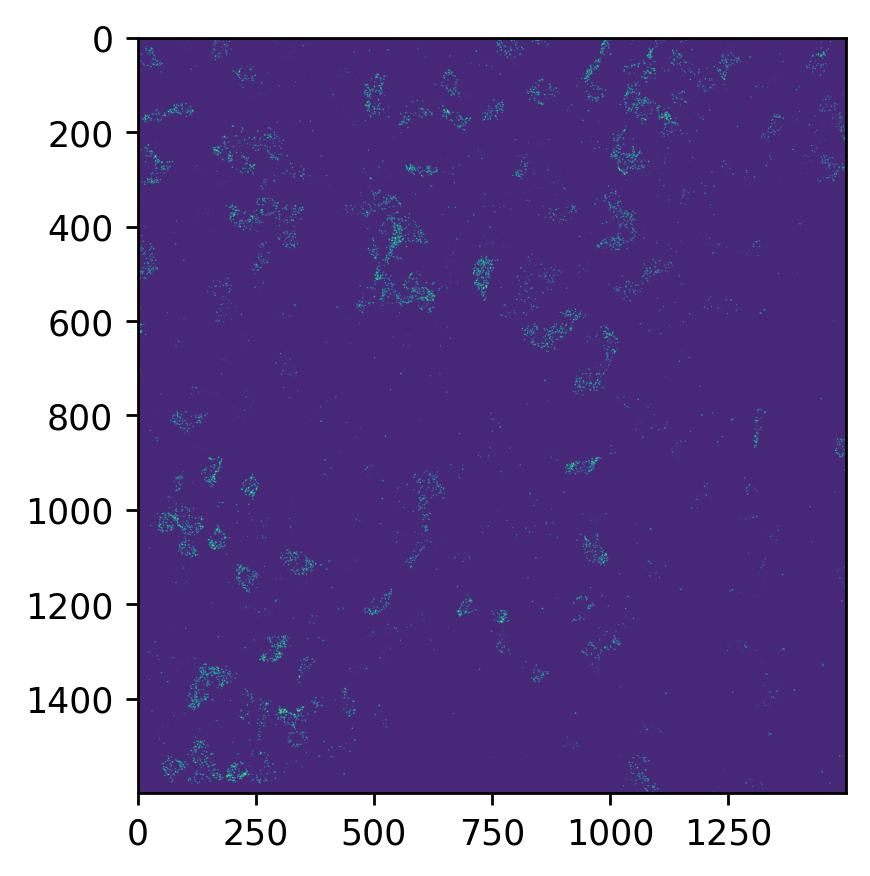

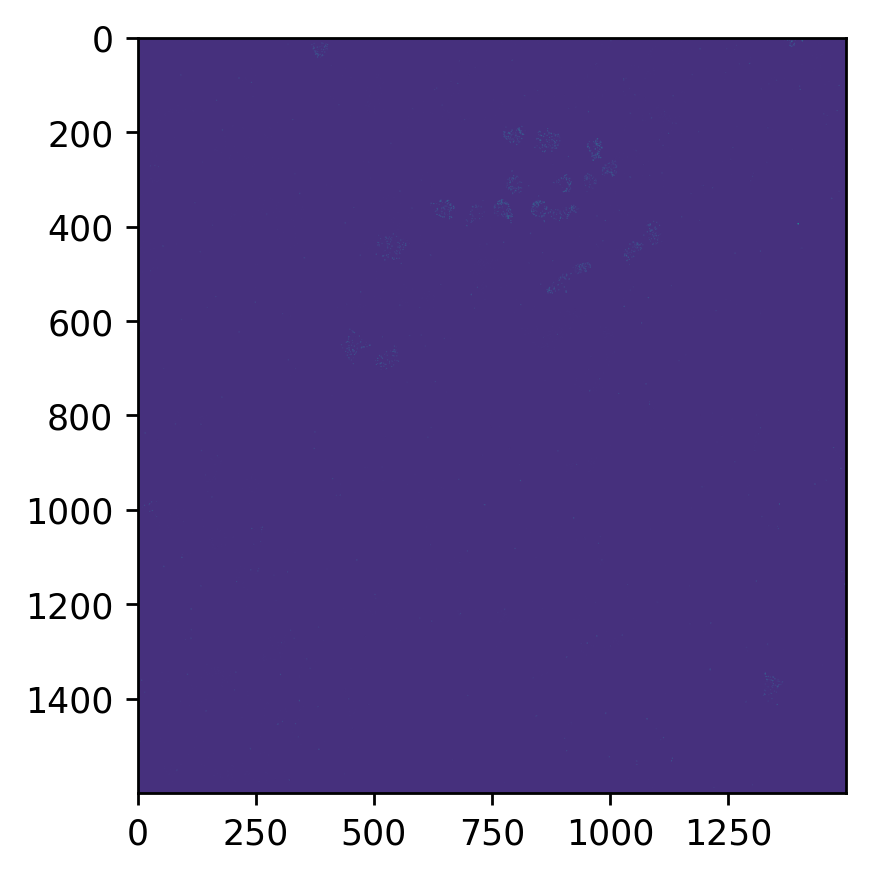

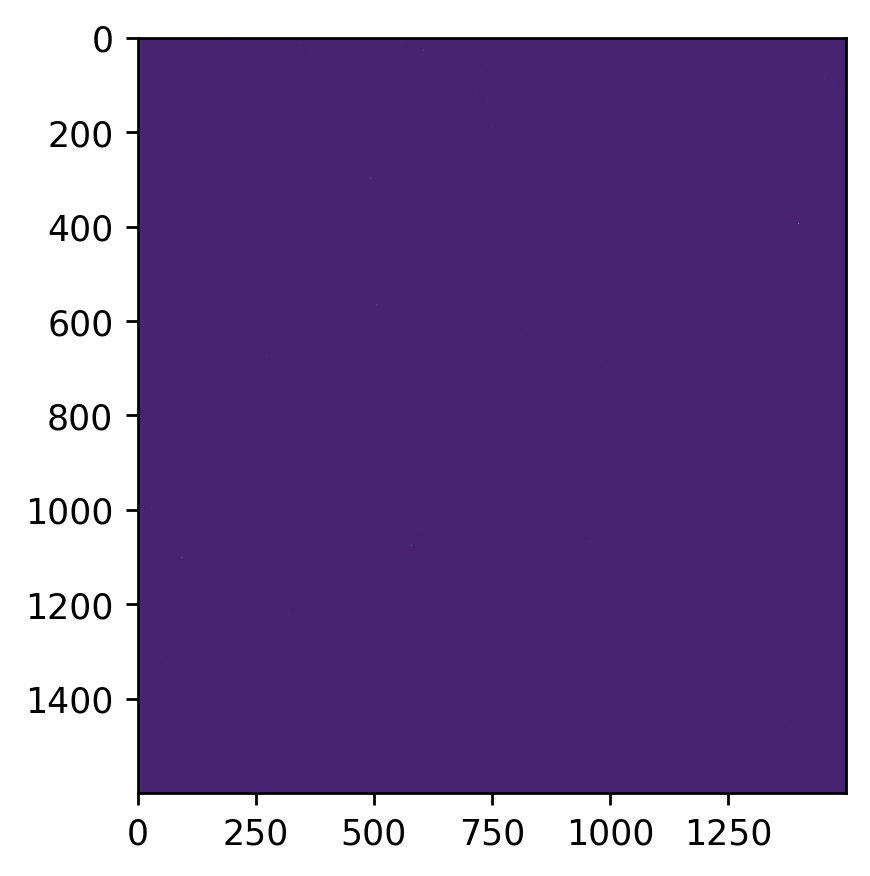

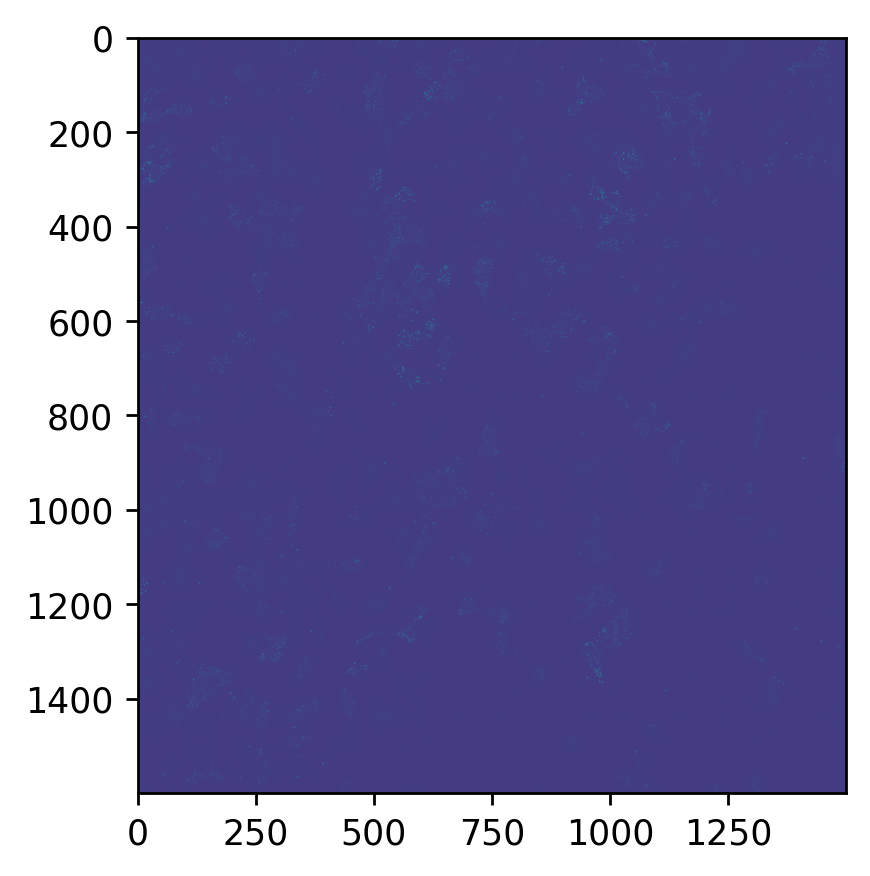

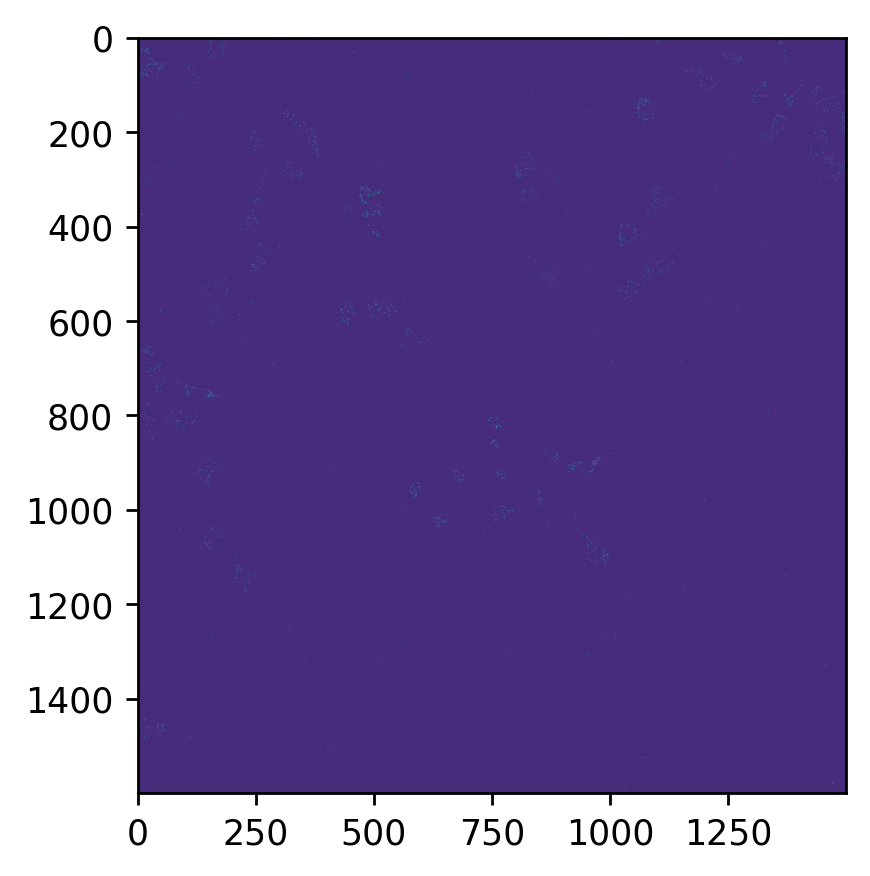

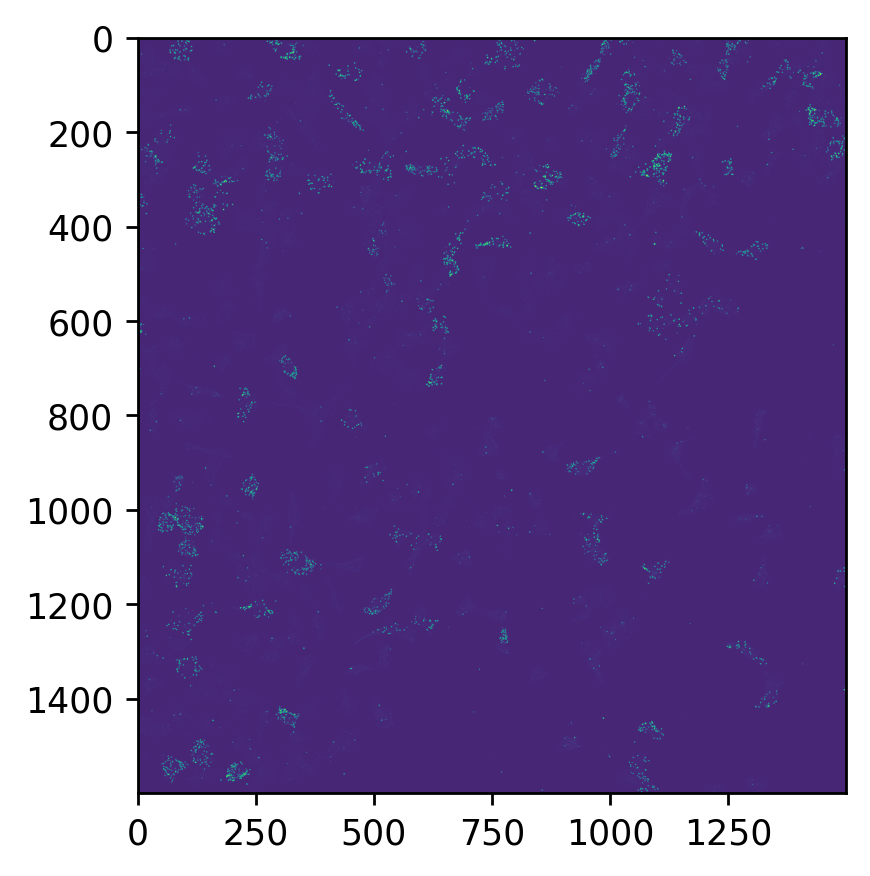

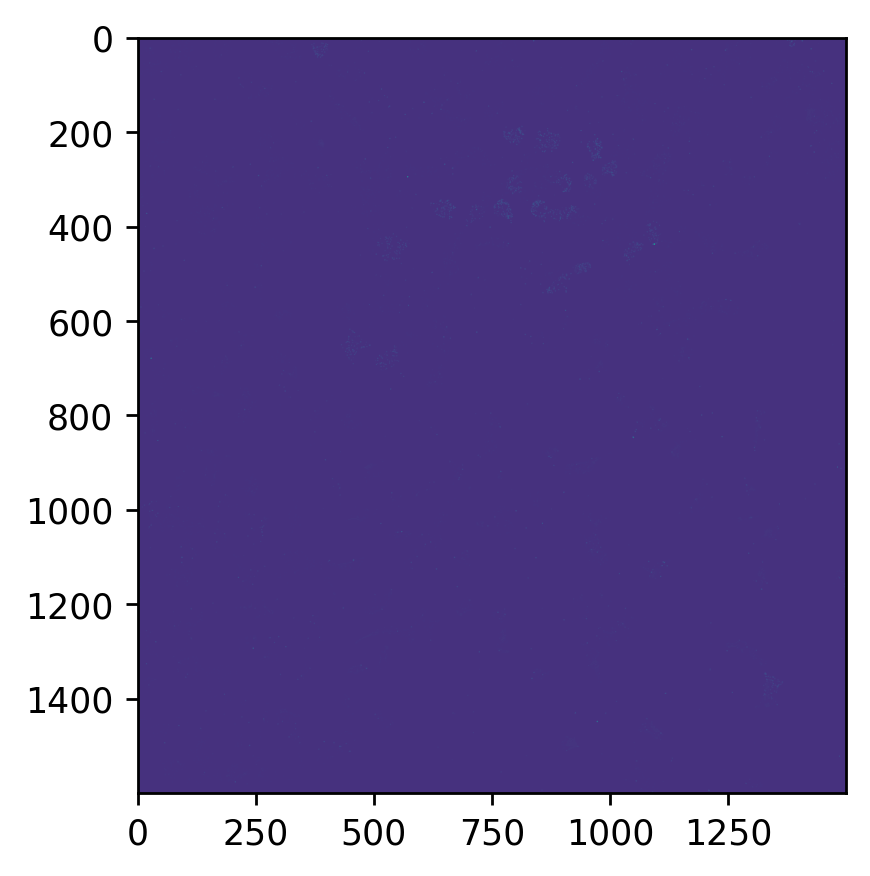

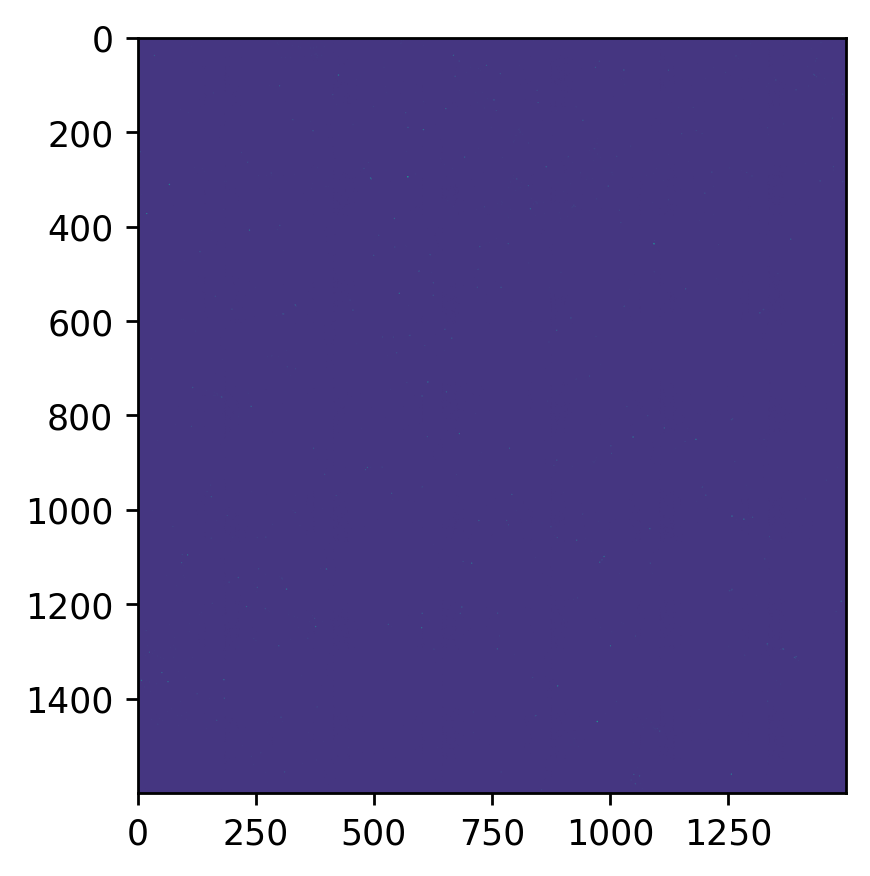

In [3]:
up = 200
down = 1800
left = 100
right = 1600

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [ ]:
for i in range(Xcenter.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(Xcenter[i, 0,])

# Codebook

In [4]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix

codebook = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [15]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [6]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [5]:
Xcenter.shape

(10, 1, 1600, 1500)

In [6]:
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [11]:
Xnorm.shape

(10, 1, 1600, 1500)

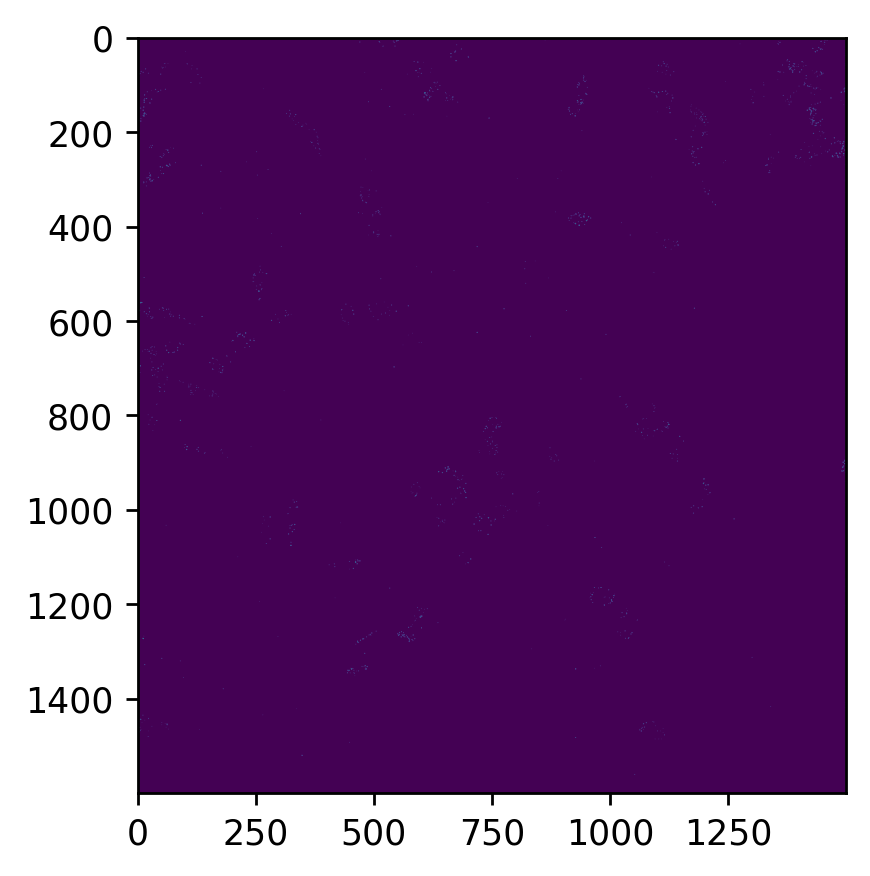

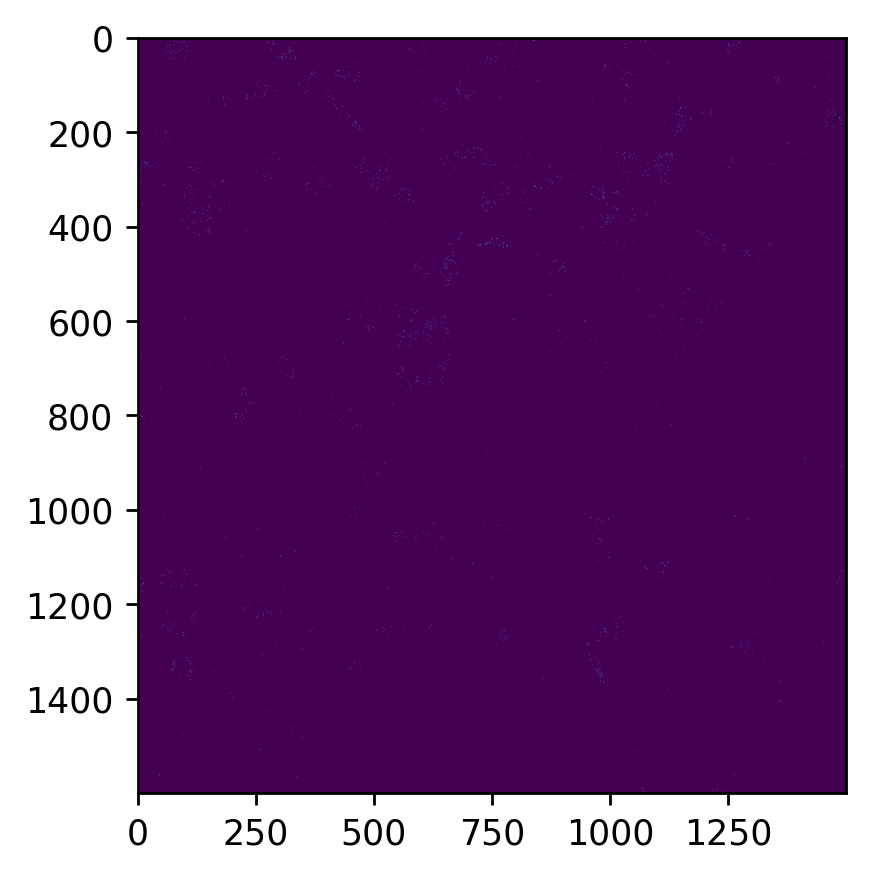

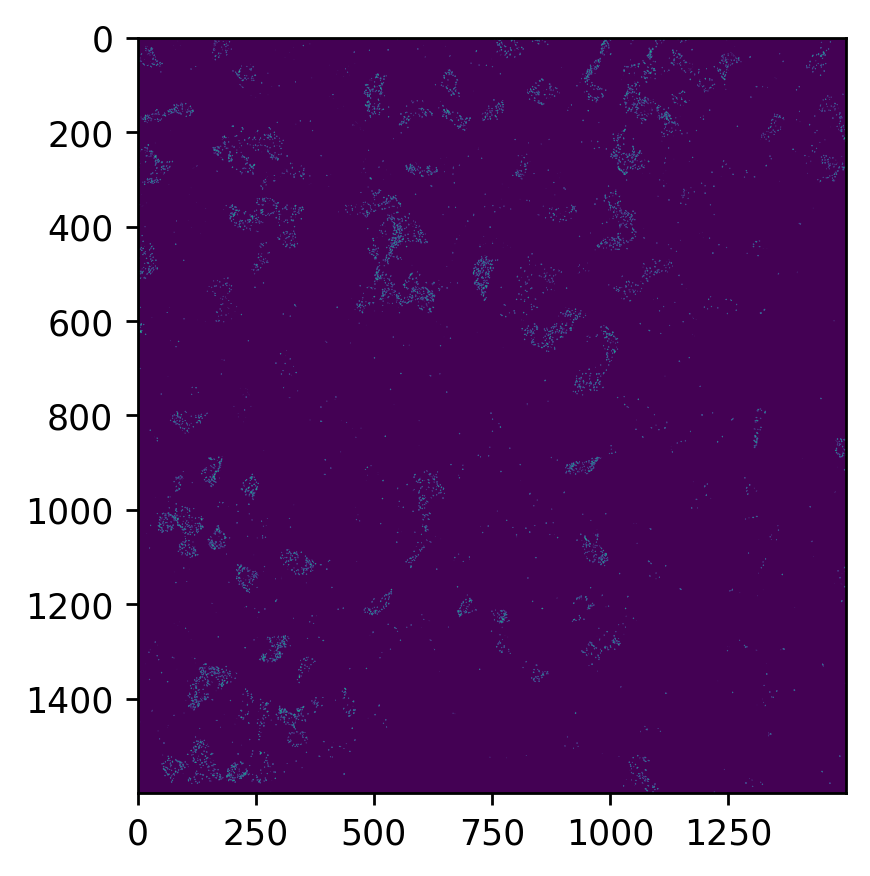

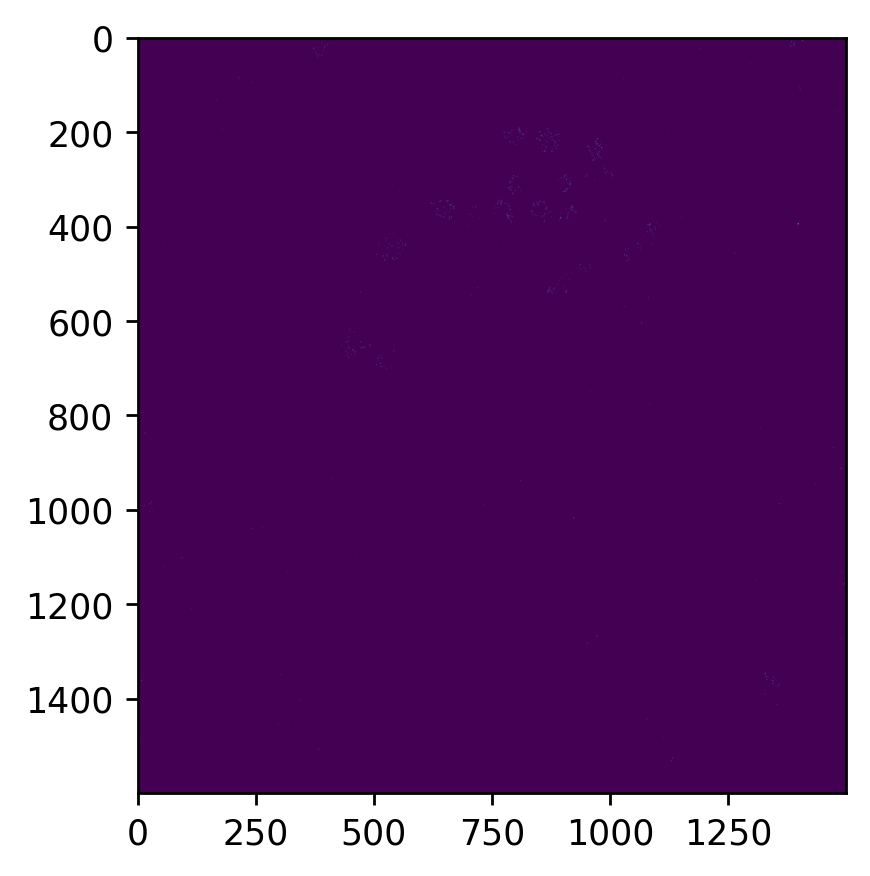

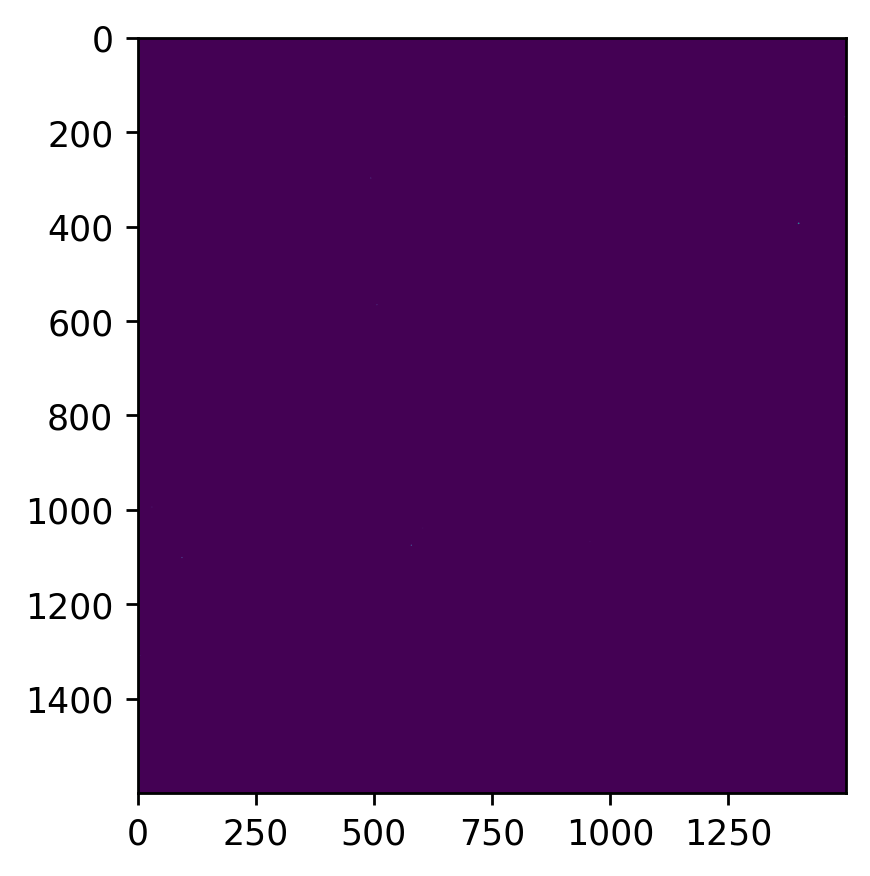

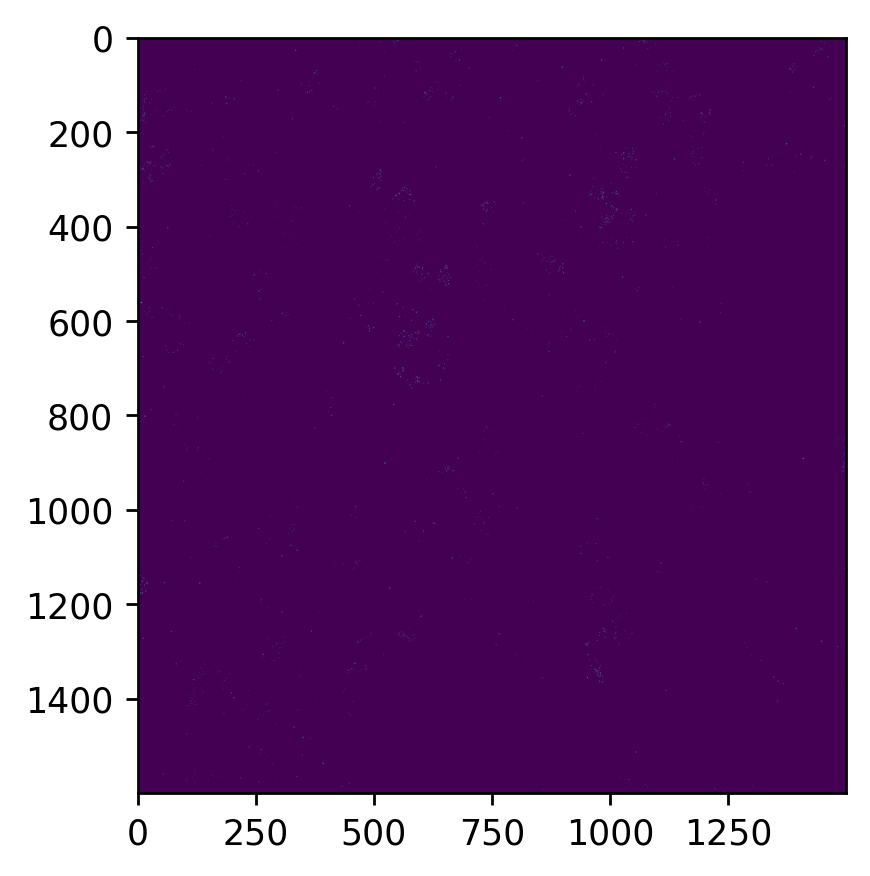

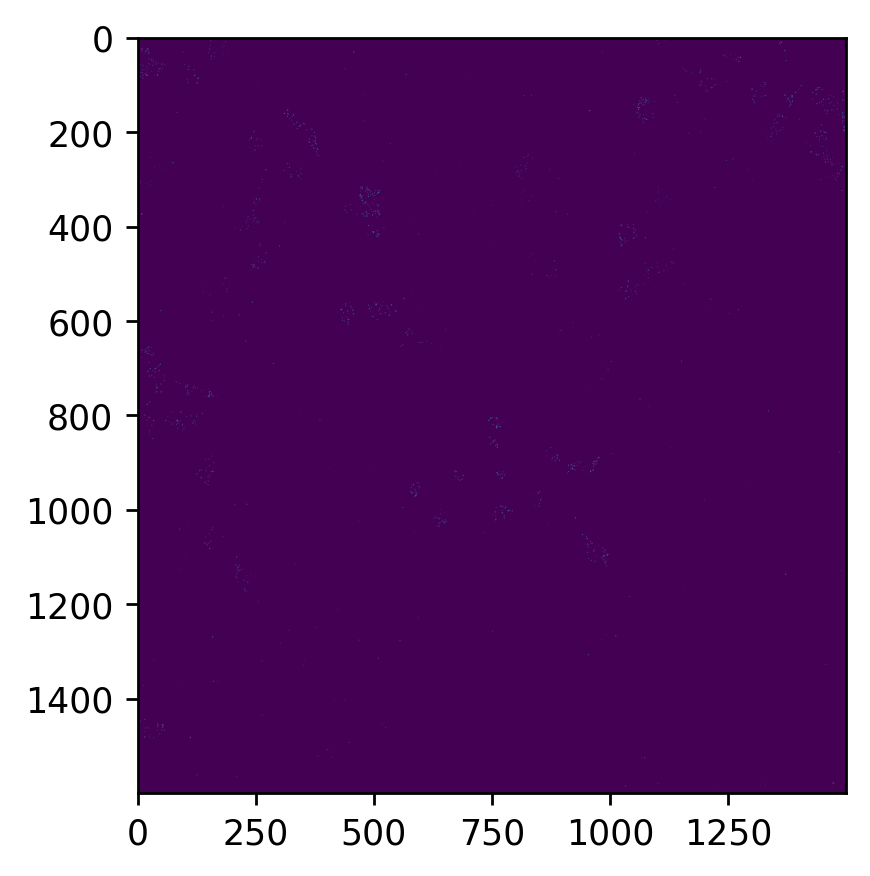

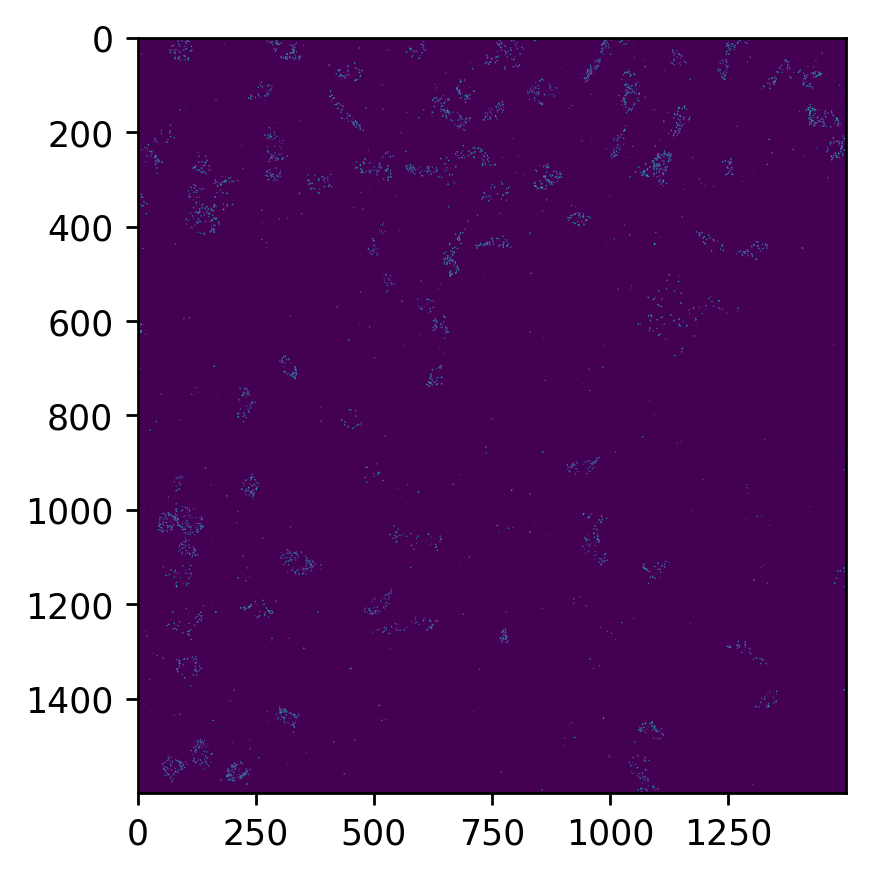

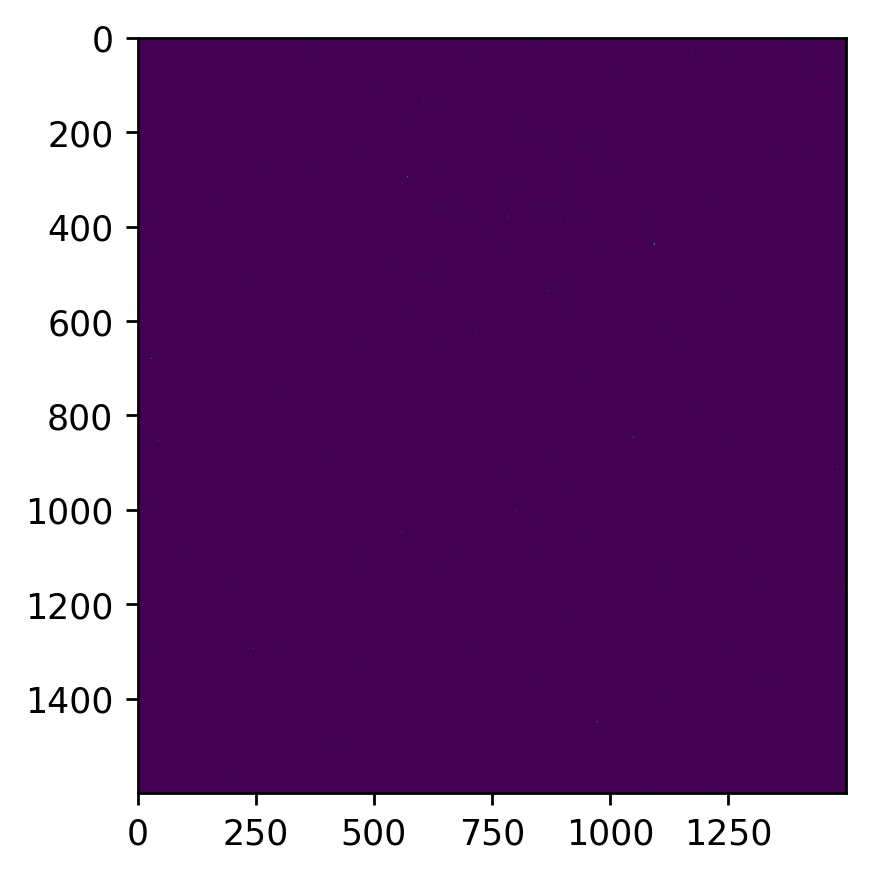

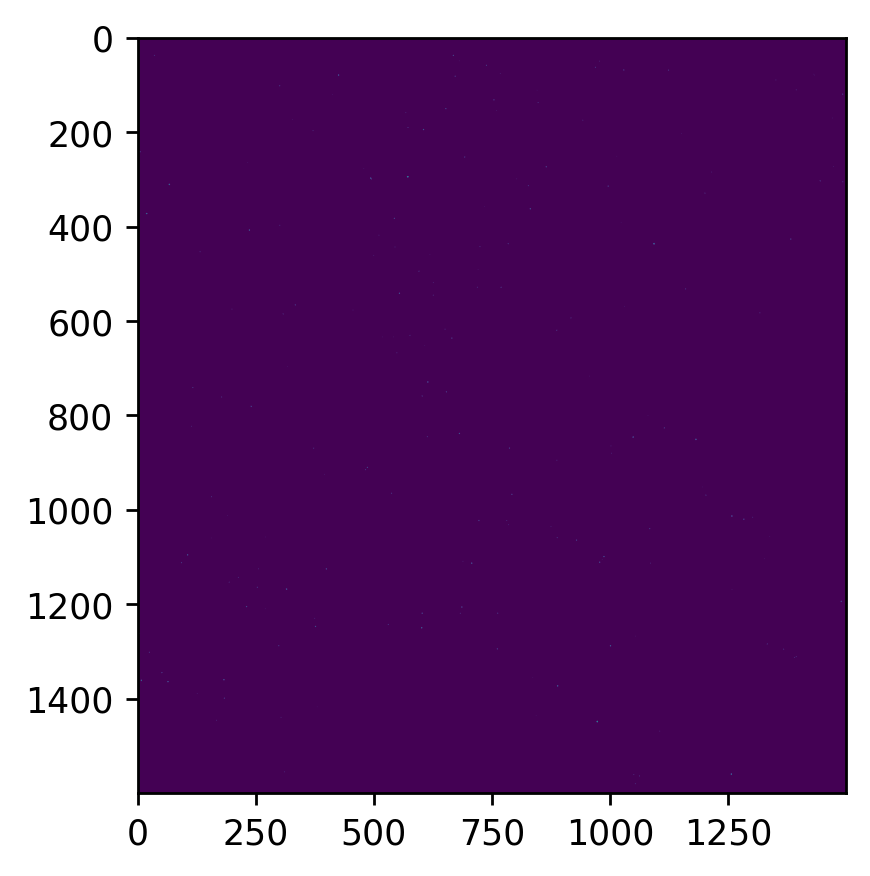

In [18]:
for i in range(Xnorm.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(Xnorm[i, 0,])

## Distribution

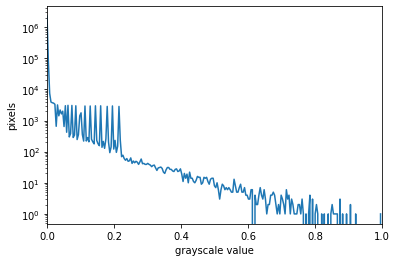

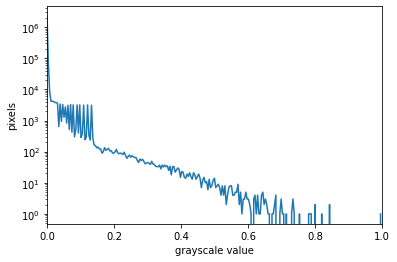

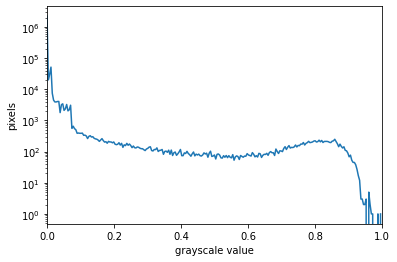

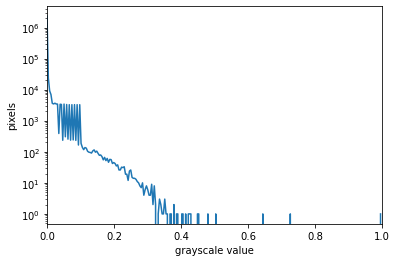

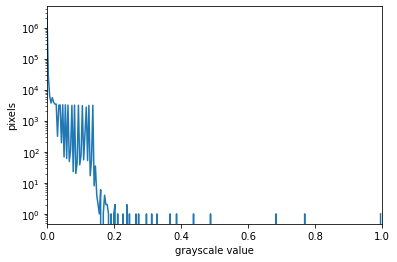

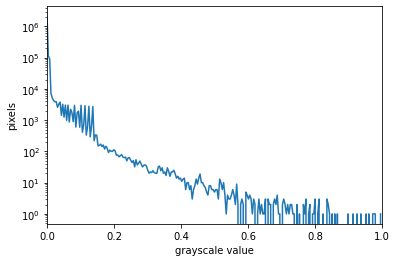

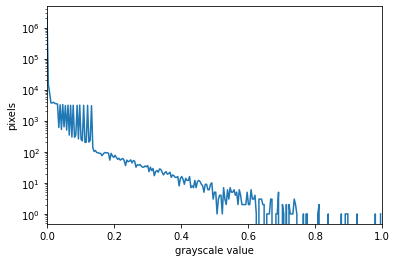

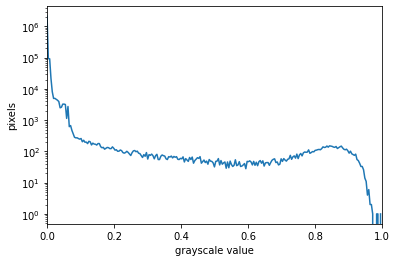

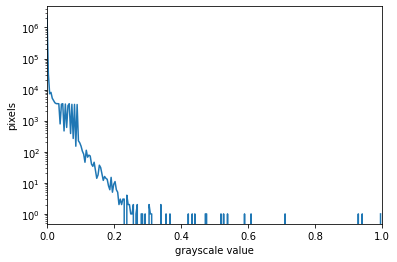

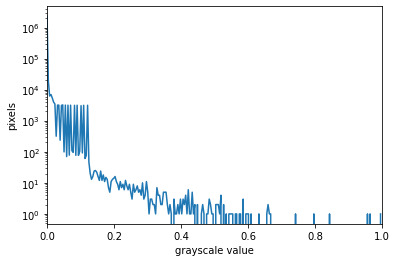

In [21]:
# create the histogram
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
#     plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

## Thresholding
Upper outliers above upper bound: set to upper bound

Lower outliers (ghost effect between cycles) below lower bound: set to 0

Then normalize the values back to [0, 1]

In [16]:
Xnorm.shape

(10, 1, 1600, 1500)

In [17]:
Xnorm[0, 0,].shape

(1600, 1500)

In [22]:
# upper = 0.9
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
# Xthresh = Xnorm.copy()
# for i in range(Xthresh.shape[0]):
#     single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
#     single[single > upper] = upper
#     Xthresh[i, 0] = single

In [7]:
residual = 0.125
Xthresh = Xnorm.copy()
Xthresh[Xthresh < residual] = 0

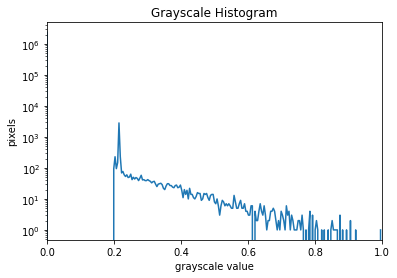

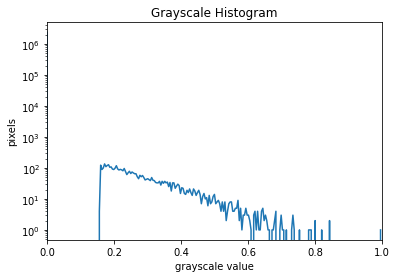

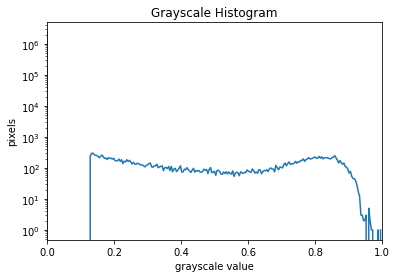

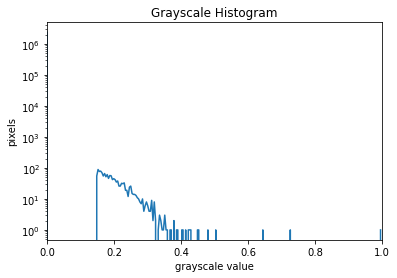

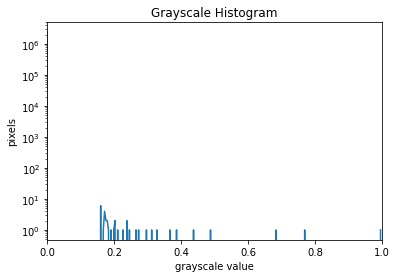

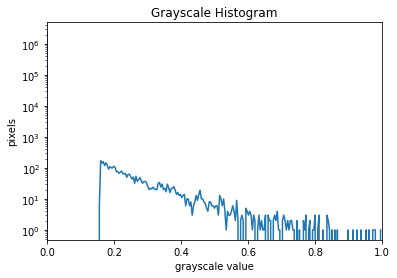

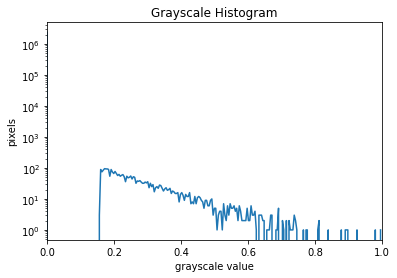

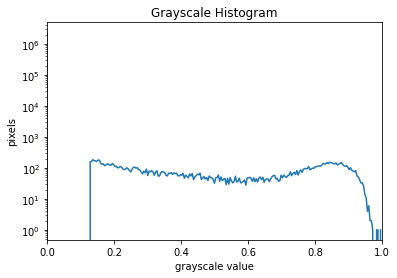

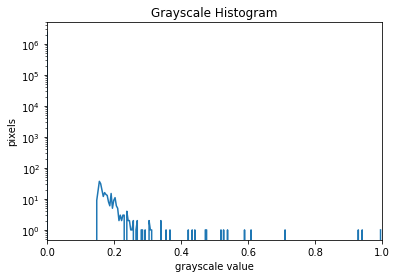

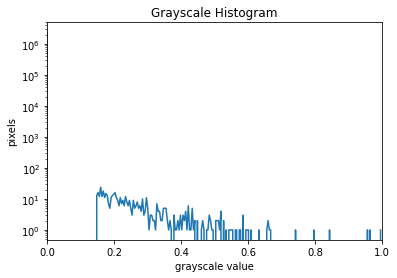

In [16]:
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

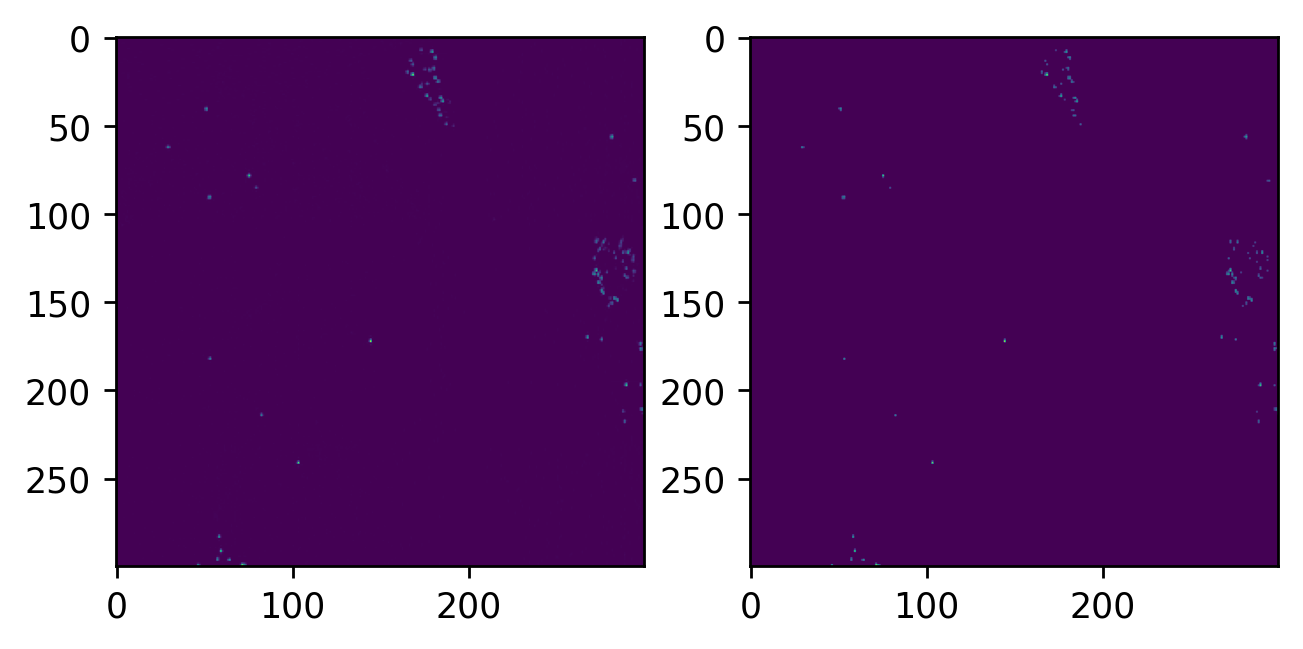

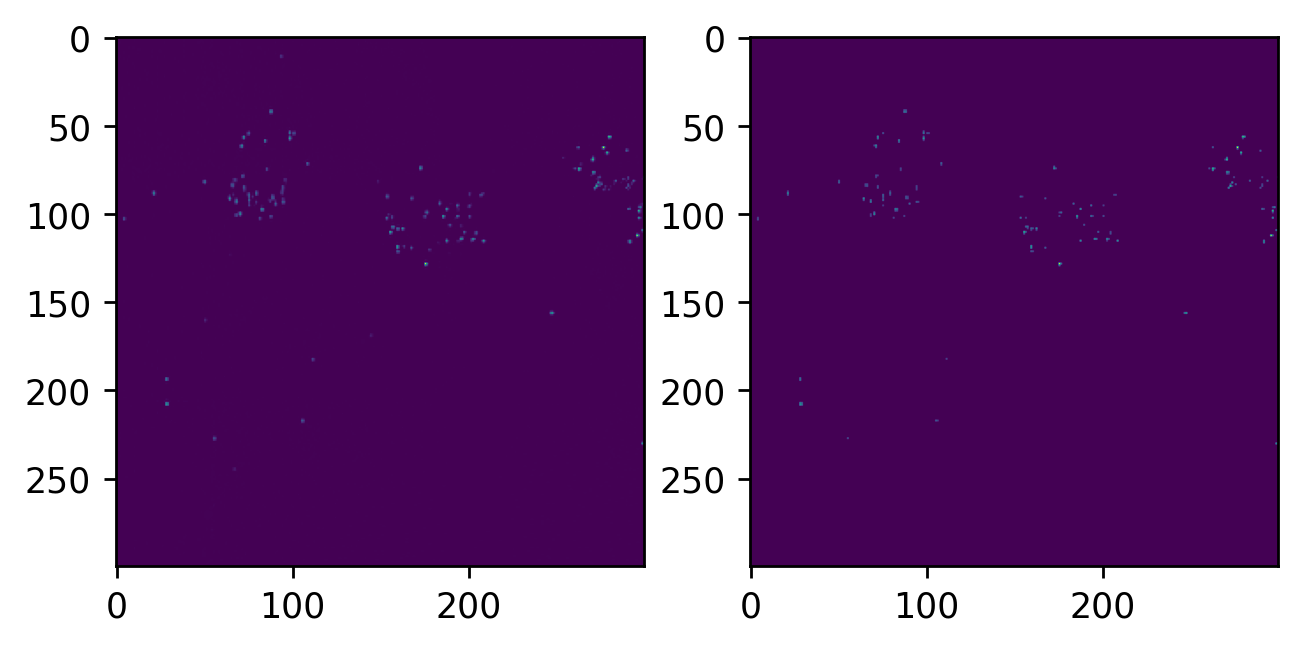

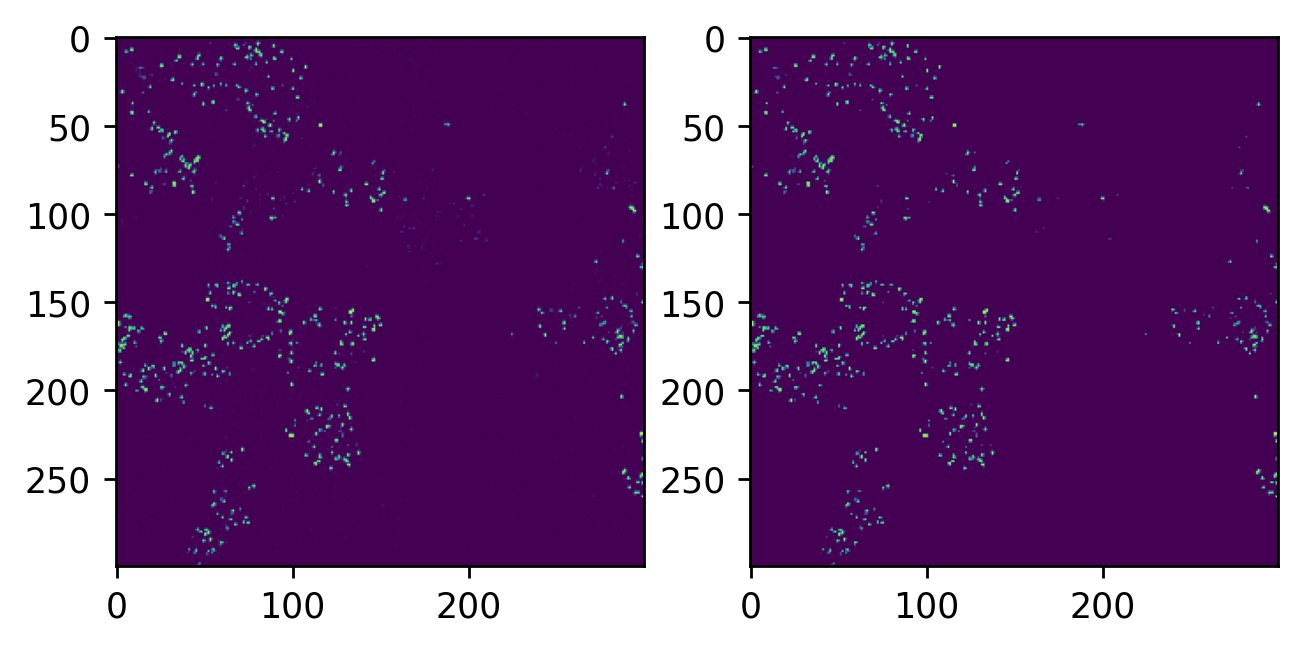

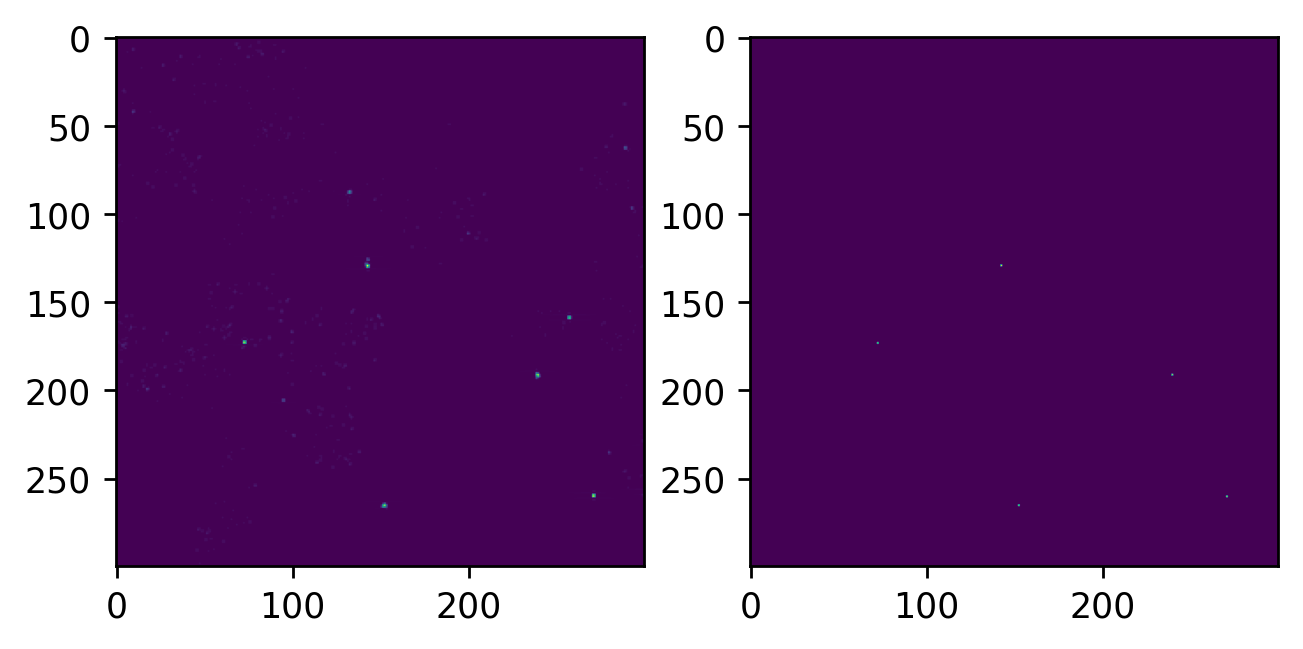

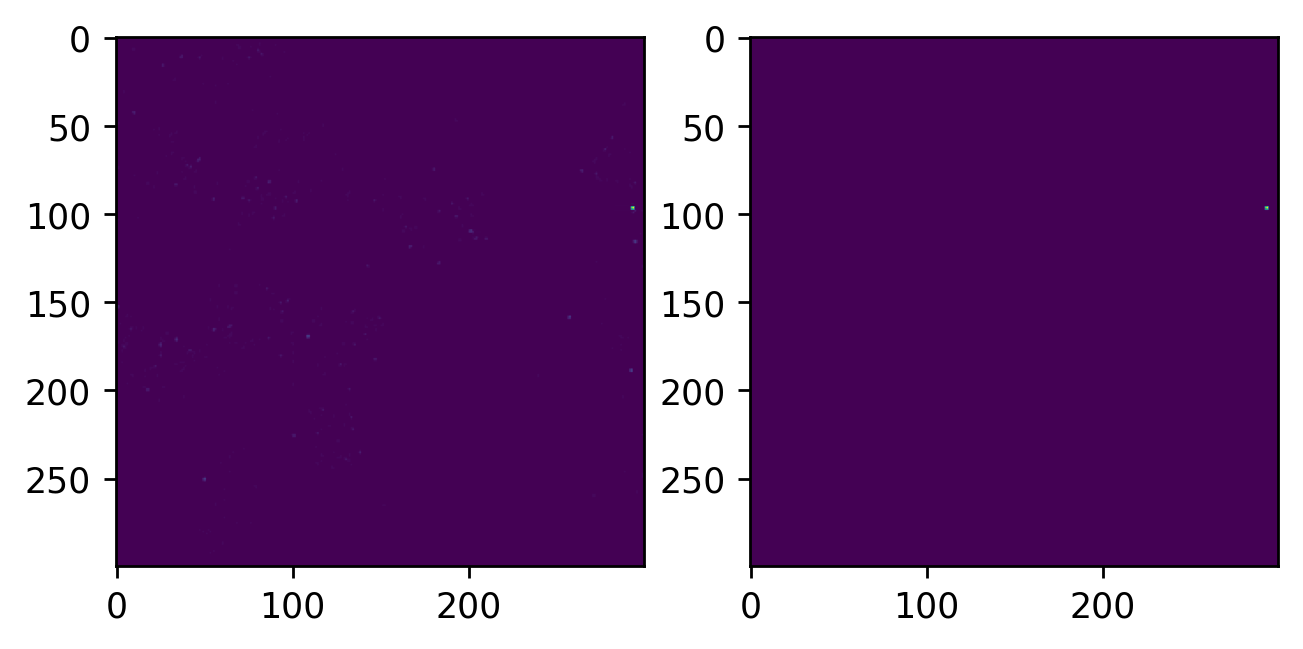

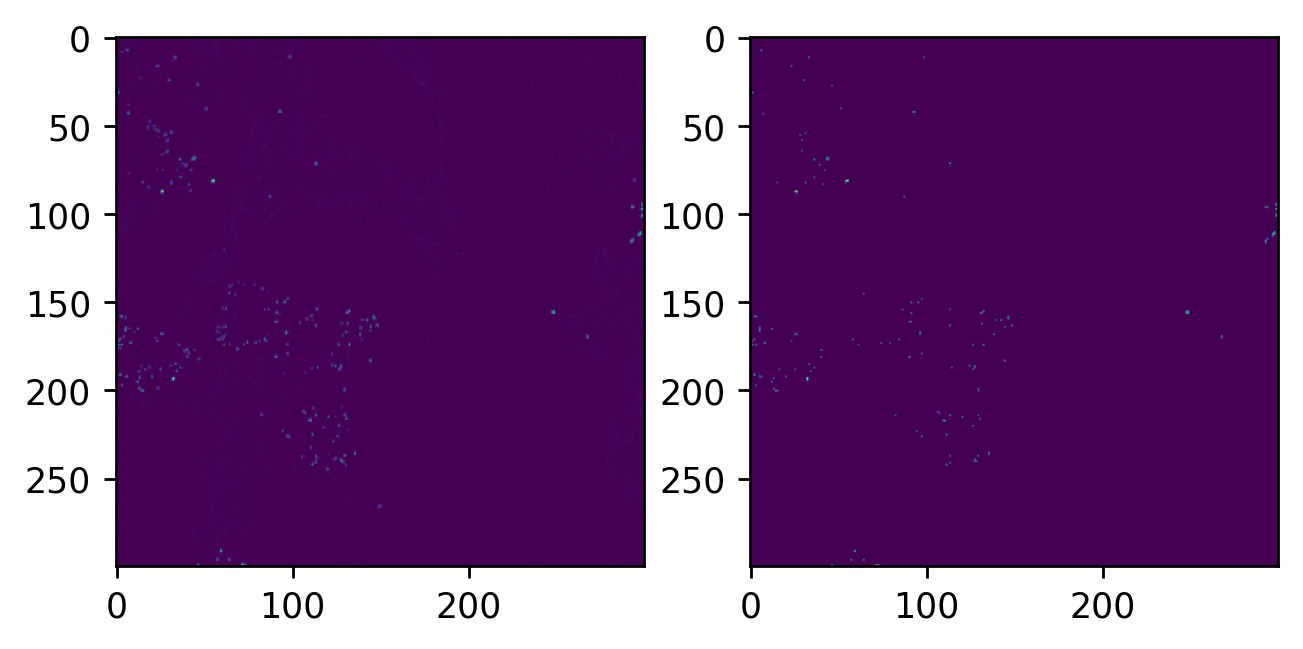

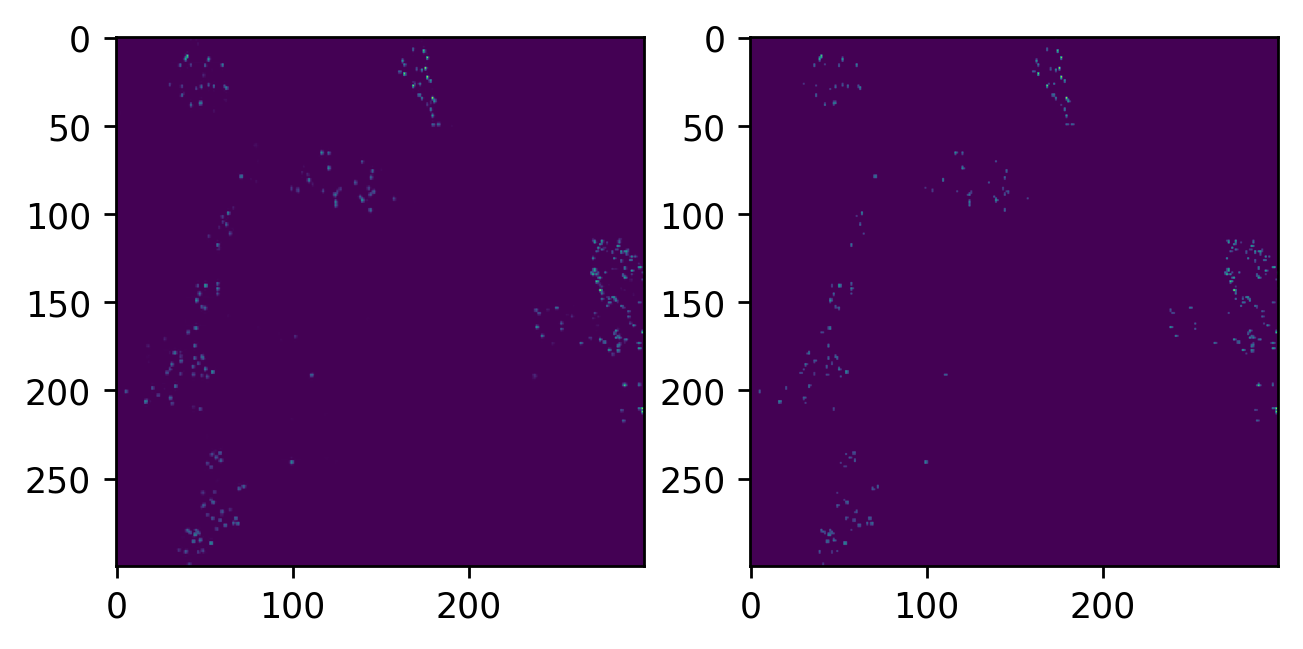

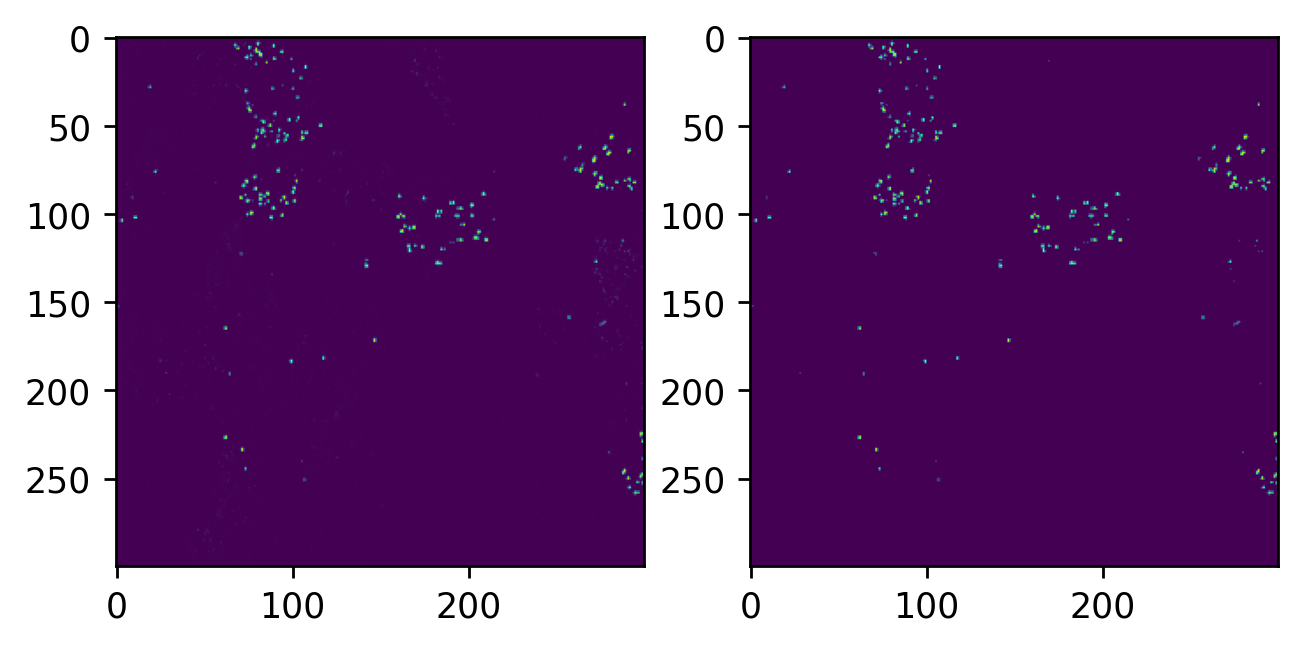

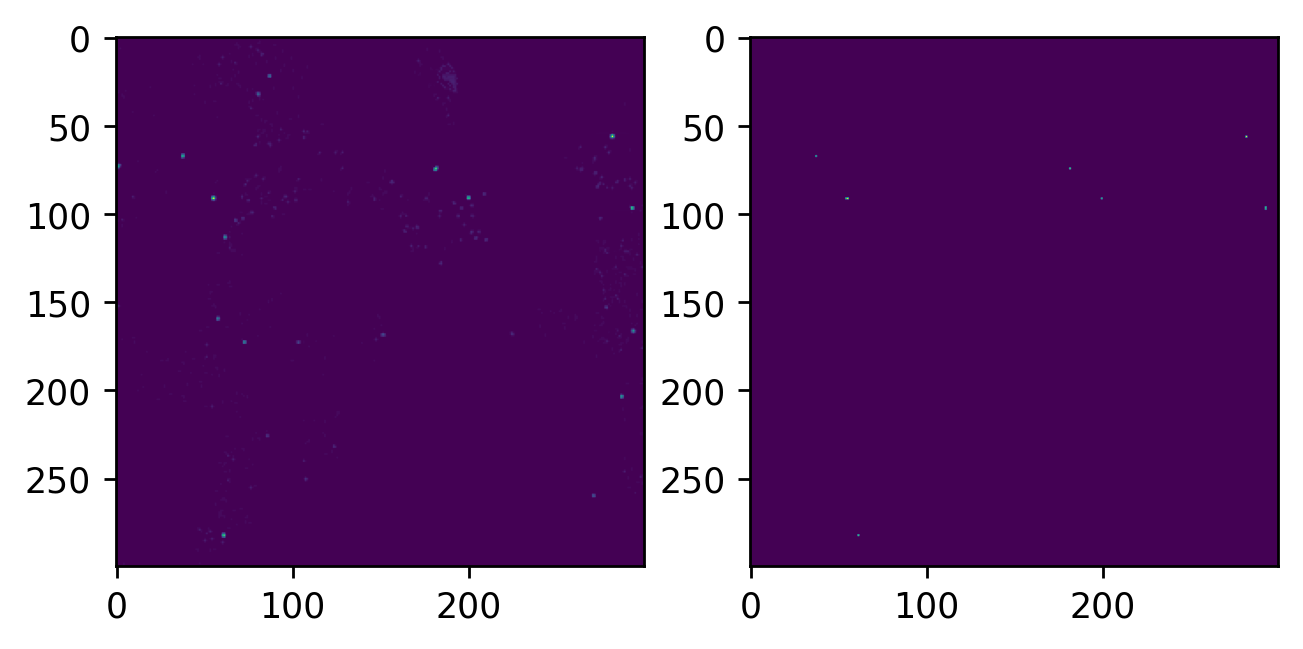

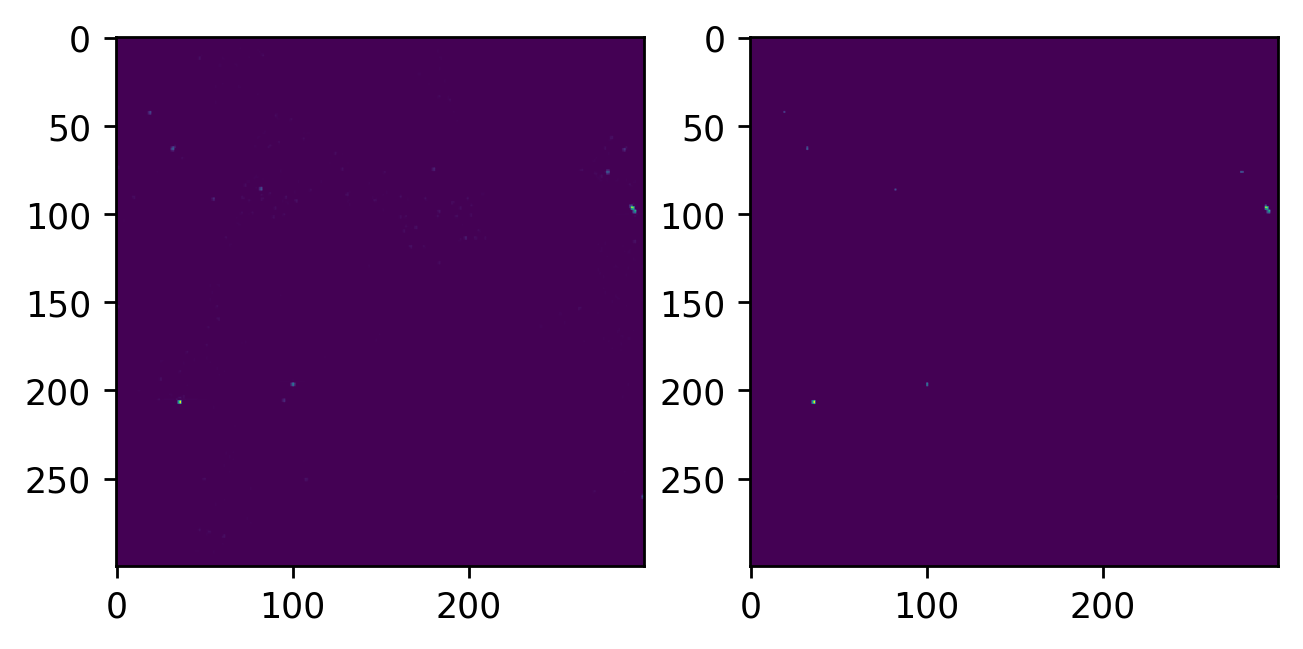

In [26]:
# Before and after (partial region)
# with bardensr.plotting.AnimAcross() as a:
for i in range(Xthresh.shape[0]):
    plt.figure(dpi=250)
    plt.subplot(1, 2, 1)
#     a('before')
    plt.imshow(Xnorm[i, 0, 200:500, 200:500])
    plt.subplot(1, 2, 2)
#     a('after')
    plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Peak calling and counting (inside membrane masks)
sun, mon

**Check by overlay to see if there are enough spots called.**

<KeysViewHDF5 ['Average GFP Masks', 'Cell Seg Mask', 'Max Projection', 'Nuc Seg Mask', 'Summed GFP Masks']>


(-0.5, 1791.5, 2047.5, -0.5)

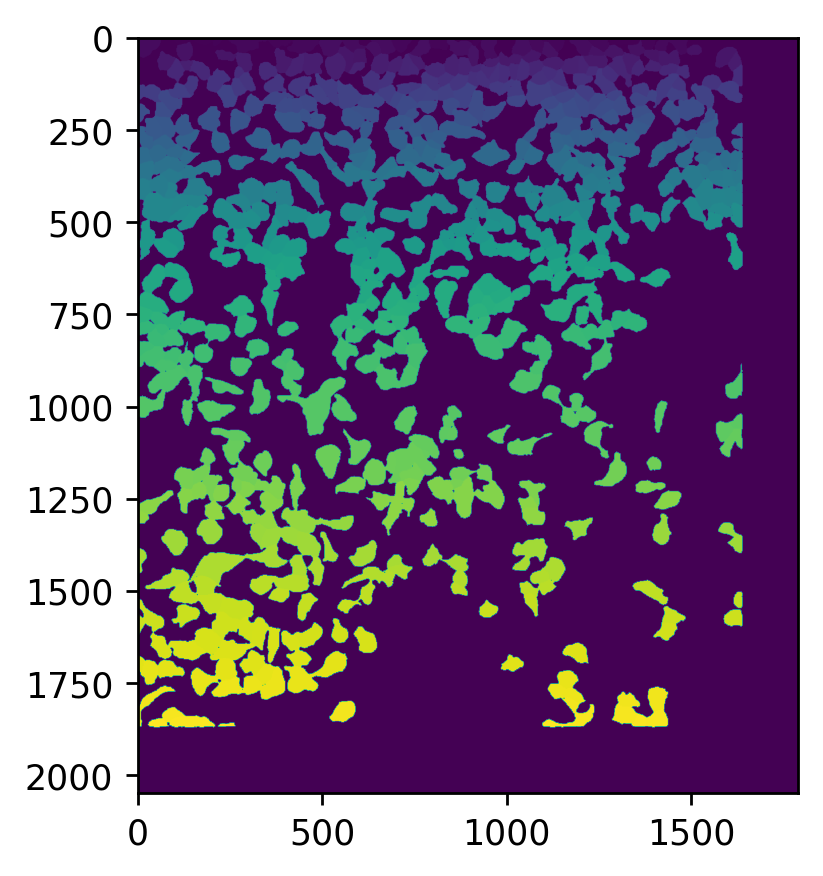

In [8]:
# Read in the membrane segmentation
hf = h5py.File("./data/Ben_MembraneSegmentation_NuclearGFP_2021-06-22.hdf5", "r")
print(hf.keys())
masks_mem = hf["Cell Seg Mask"]
plt.figure(dpi=250)
plt.imshow(masks_mem)
plt.axis('image')

In [12]:
# Find the number of membrane segmentation masks
len(np.unique(masks_mem))

660

<Figure size 1800x1200 with 0 Axes>

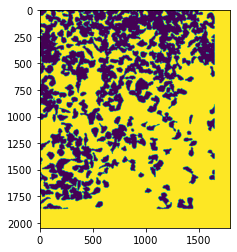

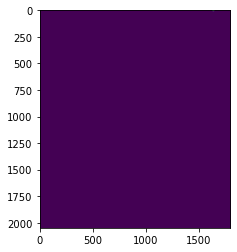

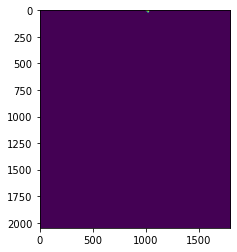

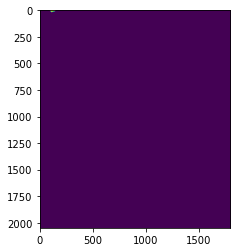

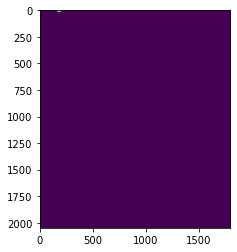

In [9]:
# Check starting from which number the masks are truly membrane segmentation (instead of the background)
plt.figure(dpi=300)
for i in range(0, 5):
    plt.figure()
    plt.imshow(np.array(masks_mem)==i)

In [ ]:
#     xindex = test.loc[i, 'm2'] + left
#     yindex = test.loc[i, 'm1'] + up

In [57]:
# pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))

In [59]:
# cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

for k in range(Xthresh.shape[0]):
    # Get local maximum values of desired neighborhood (size of the amplicons)
    max_fil = ndimage.maximum_filter(Xthresh[k,], size=(1, 2, 2))

    # Threshold the image to find locations of interest
    # assuming 6 standard deviations above the mean of the image
    peak_thresh = max_fil.mean() + max_fil.std() * 6

    # find areas greater than peak_thresh
    labels, num_labels = ndimage.label(max_fil > peak_thresh)

    # Get the positions of the maxima
    coords = ndimage.measurements.center_of_mass(Xthresh[k,], 
                                                 labels=labels, 
                                                 index=np.arange(1, num_labels + 1))

    # # Get the maximum value in the labels
    # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
    # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

    for _, m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # import to match the coordinates if images are trimmed
        if mem_id>0:
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [42]:
labels

array([[[  1,   1,   1, ...,   3,   3,   3],
        [  1,   1,   1, ...,   3,   3,   3],
        [  1,   1,   1, ...,   3,   3,   3],
        ...,
        [  1,   1,   1, ..., 395, 395, 395],
        [  1,   1,   1, ..., 395, 395, 395],
        [  1,   1,   1, ..., 395, 395, 395]]], dtype=int32)

In [43]:
num_labels

1165

In [54]:
coords[:10]

[(0.0, 801.5228444869555, 1.4139379993961498),
 (0.0, 1.7992734679099214, 506.22573616105615),
 (0.0, 122.46993659493441, 1497.9150611805899),
 (0.0, 1.3921734180586105, 1215.4843527841685),
 (0.0, 1.0, 1331.4946533118566),
 (0.0, 2.0052169496357606, 1453.729200041545),
 (0.0, 3.5409793461432555, 1459.4833098930824),
 (0.0, 5.08831904126936, 549.0203583193372),
 (0.0, 4.0, 861.5770890363256),
 (0.0, 7.676076161423661, 541.7462505139135)]

In [22]:
int(np.round(801.5228444869555))

802

In [47]:
len(coords)

1165

In [35]:
cell_table

0    1    2    3    4    5    6    7    8    9
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
655  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
656  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
657  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
658  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
659  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[660 rows x 10 columns]

In [38]:
cell_table.loc[200:205, ]

0     1     2    3    4     5    6     7    8    9
200  13.0   1.0   3.0  0.0  0.0  14.0  1.0   1.0  0.0  1.0
201   9.0   0.0   1.0  0.0  0.0   3.0  1.0  16.0  0.0  0.0
202   0.0   2.0  20.0  2.0  0.0   1.0  0.0   0.0  0.0  0.0
203  10.0   2.0   0.0  0.0  0.0   8.0  0.0   0.0  0.0  0.0
204   0.0   0.0   0.0  0.0  0.0   0.0  0.0   0.0  0.0  0.0
205   1.0  19.0   2.0  0.0  0.0   0.0  1.0  18.0  1.0  1.0

# Correlation

In [71]:
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
cell_corr[200:205,]

array([[1.38873008, 0.        , 0.10286889, 0.05143445, 0.20573779,
        0.77151671, 0.8743856 , 0.72008226, 0.20573779, 0.10286889],
       [0.64326749, 0.        , 0.05360562, 0.        , 0.91129561,
        0.16081687, 0.2144225 , 0.53605624, 0.10721125, 0.85768998],
       [0.04944682, 0.09889363, 0.09889363, 0.        , 0.9889363 ,
        0.14834045, 1.03838312, 0.        , 0.9889363 , 0.09889363],
       [1.38873004, 0.        , 0.15430334, 0.        , 0.        ,
        0.77151669, 0.61721335, 0.77151669, 0.        , 0.15430334],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [64]:
# cell_norm + 1e-6

In [73]:
# (cell_table.dot(codebook.T) / np.reshape(cell_norm, (-1,1))).shape

In [70]:
# cell_norm

In [69]:
# np.reshape(cell_norm, (-1,1))

In [74]:
cell_id = np.argmax(cell_corr, axis=1)

In [77]:
pd.DataFrame(cell_id).loc[200:210]

0
200  0
201  4
202  6
203  0
204  0
205  9
206  7
207  6
208  7
209  0
210  9

In [68]:
# result_corr.to_csv('crisprmap20210506_layer1out0123_result_corr_thresh72_preprocessed.csv', index=False)